# Analiza danych otrzymanych z systemu pomiarowego
## Wykonawcy:
 - inż. Mateusz Bartoszewicz
 - inż. Maciej Siłkowski
 - inż. Stanisław Rachwał

## Opiekun projektu:
 - dr inż. Paweł Syty

# Prezentacja urządzenia i systemu pomiarowego


## Urządzenie:
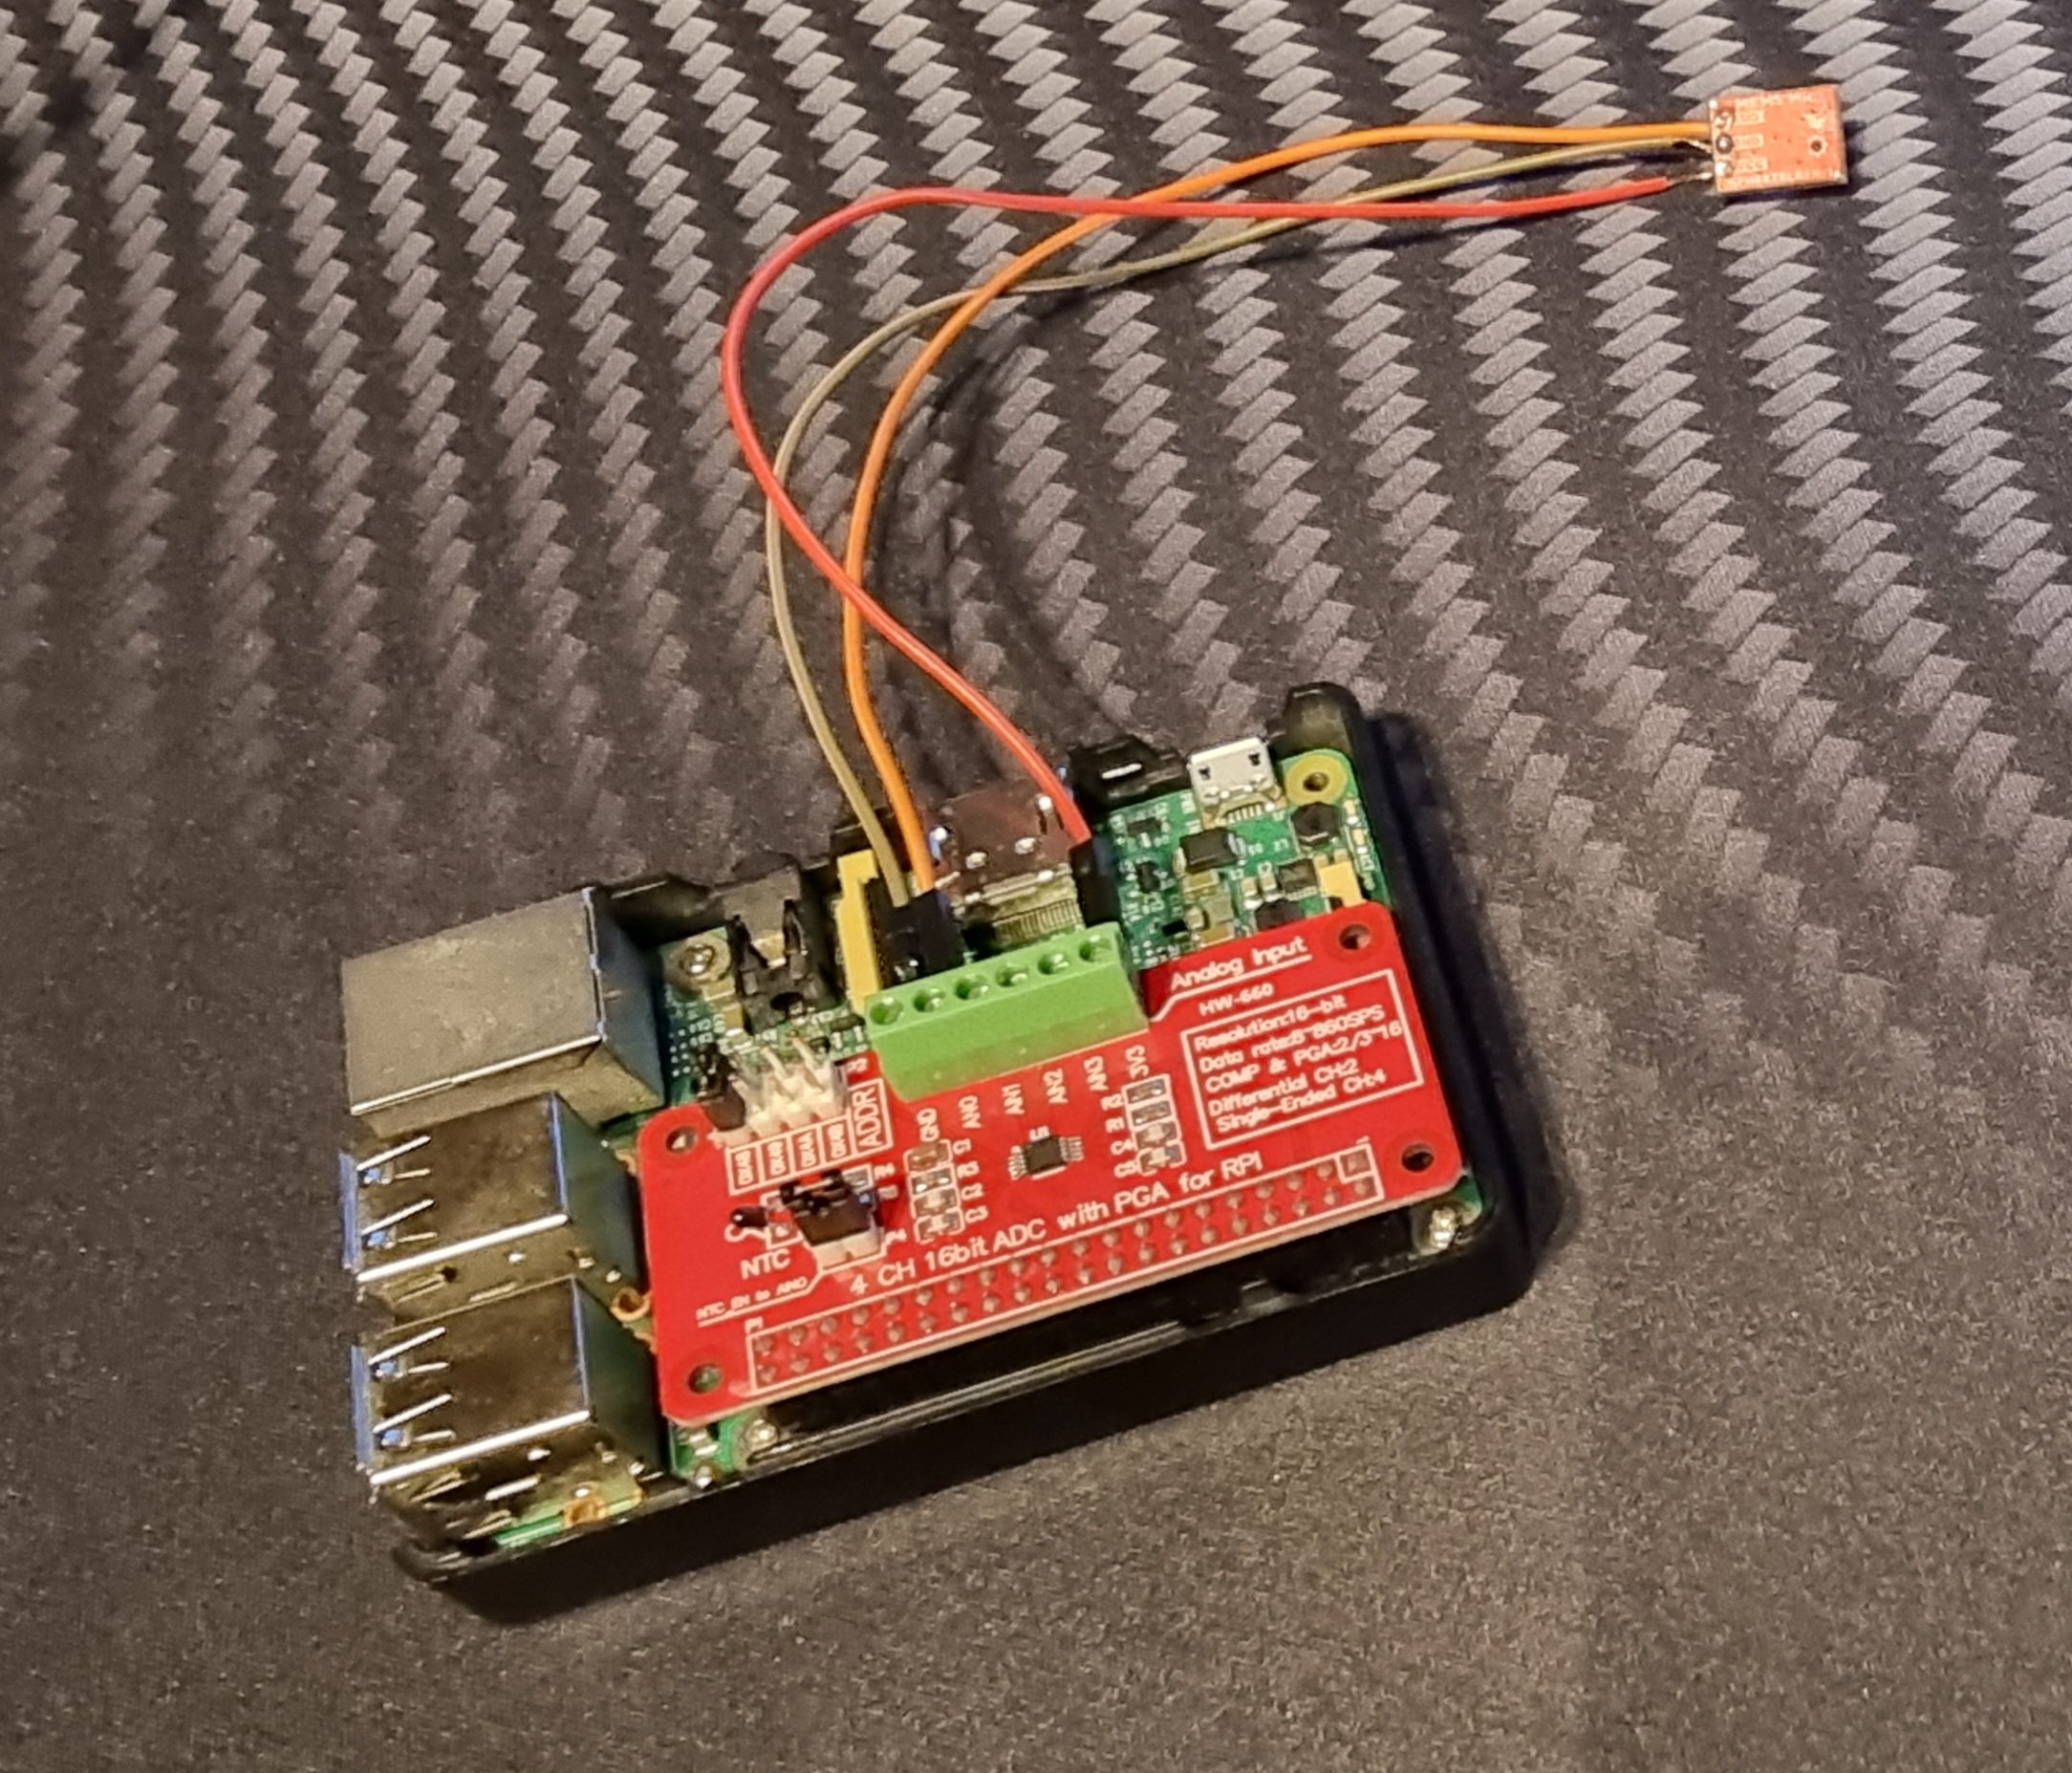

## System:
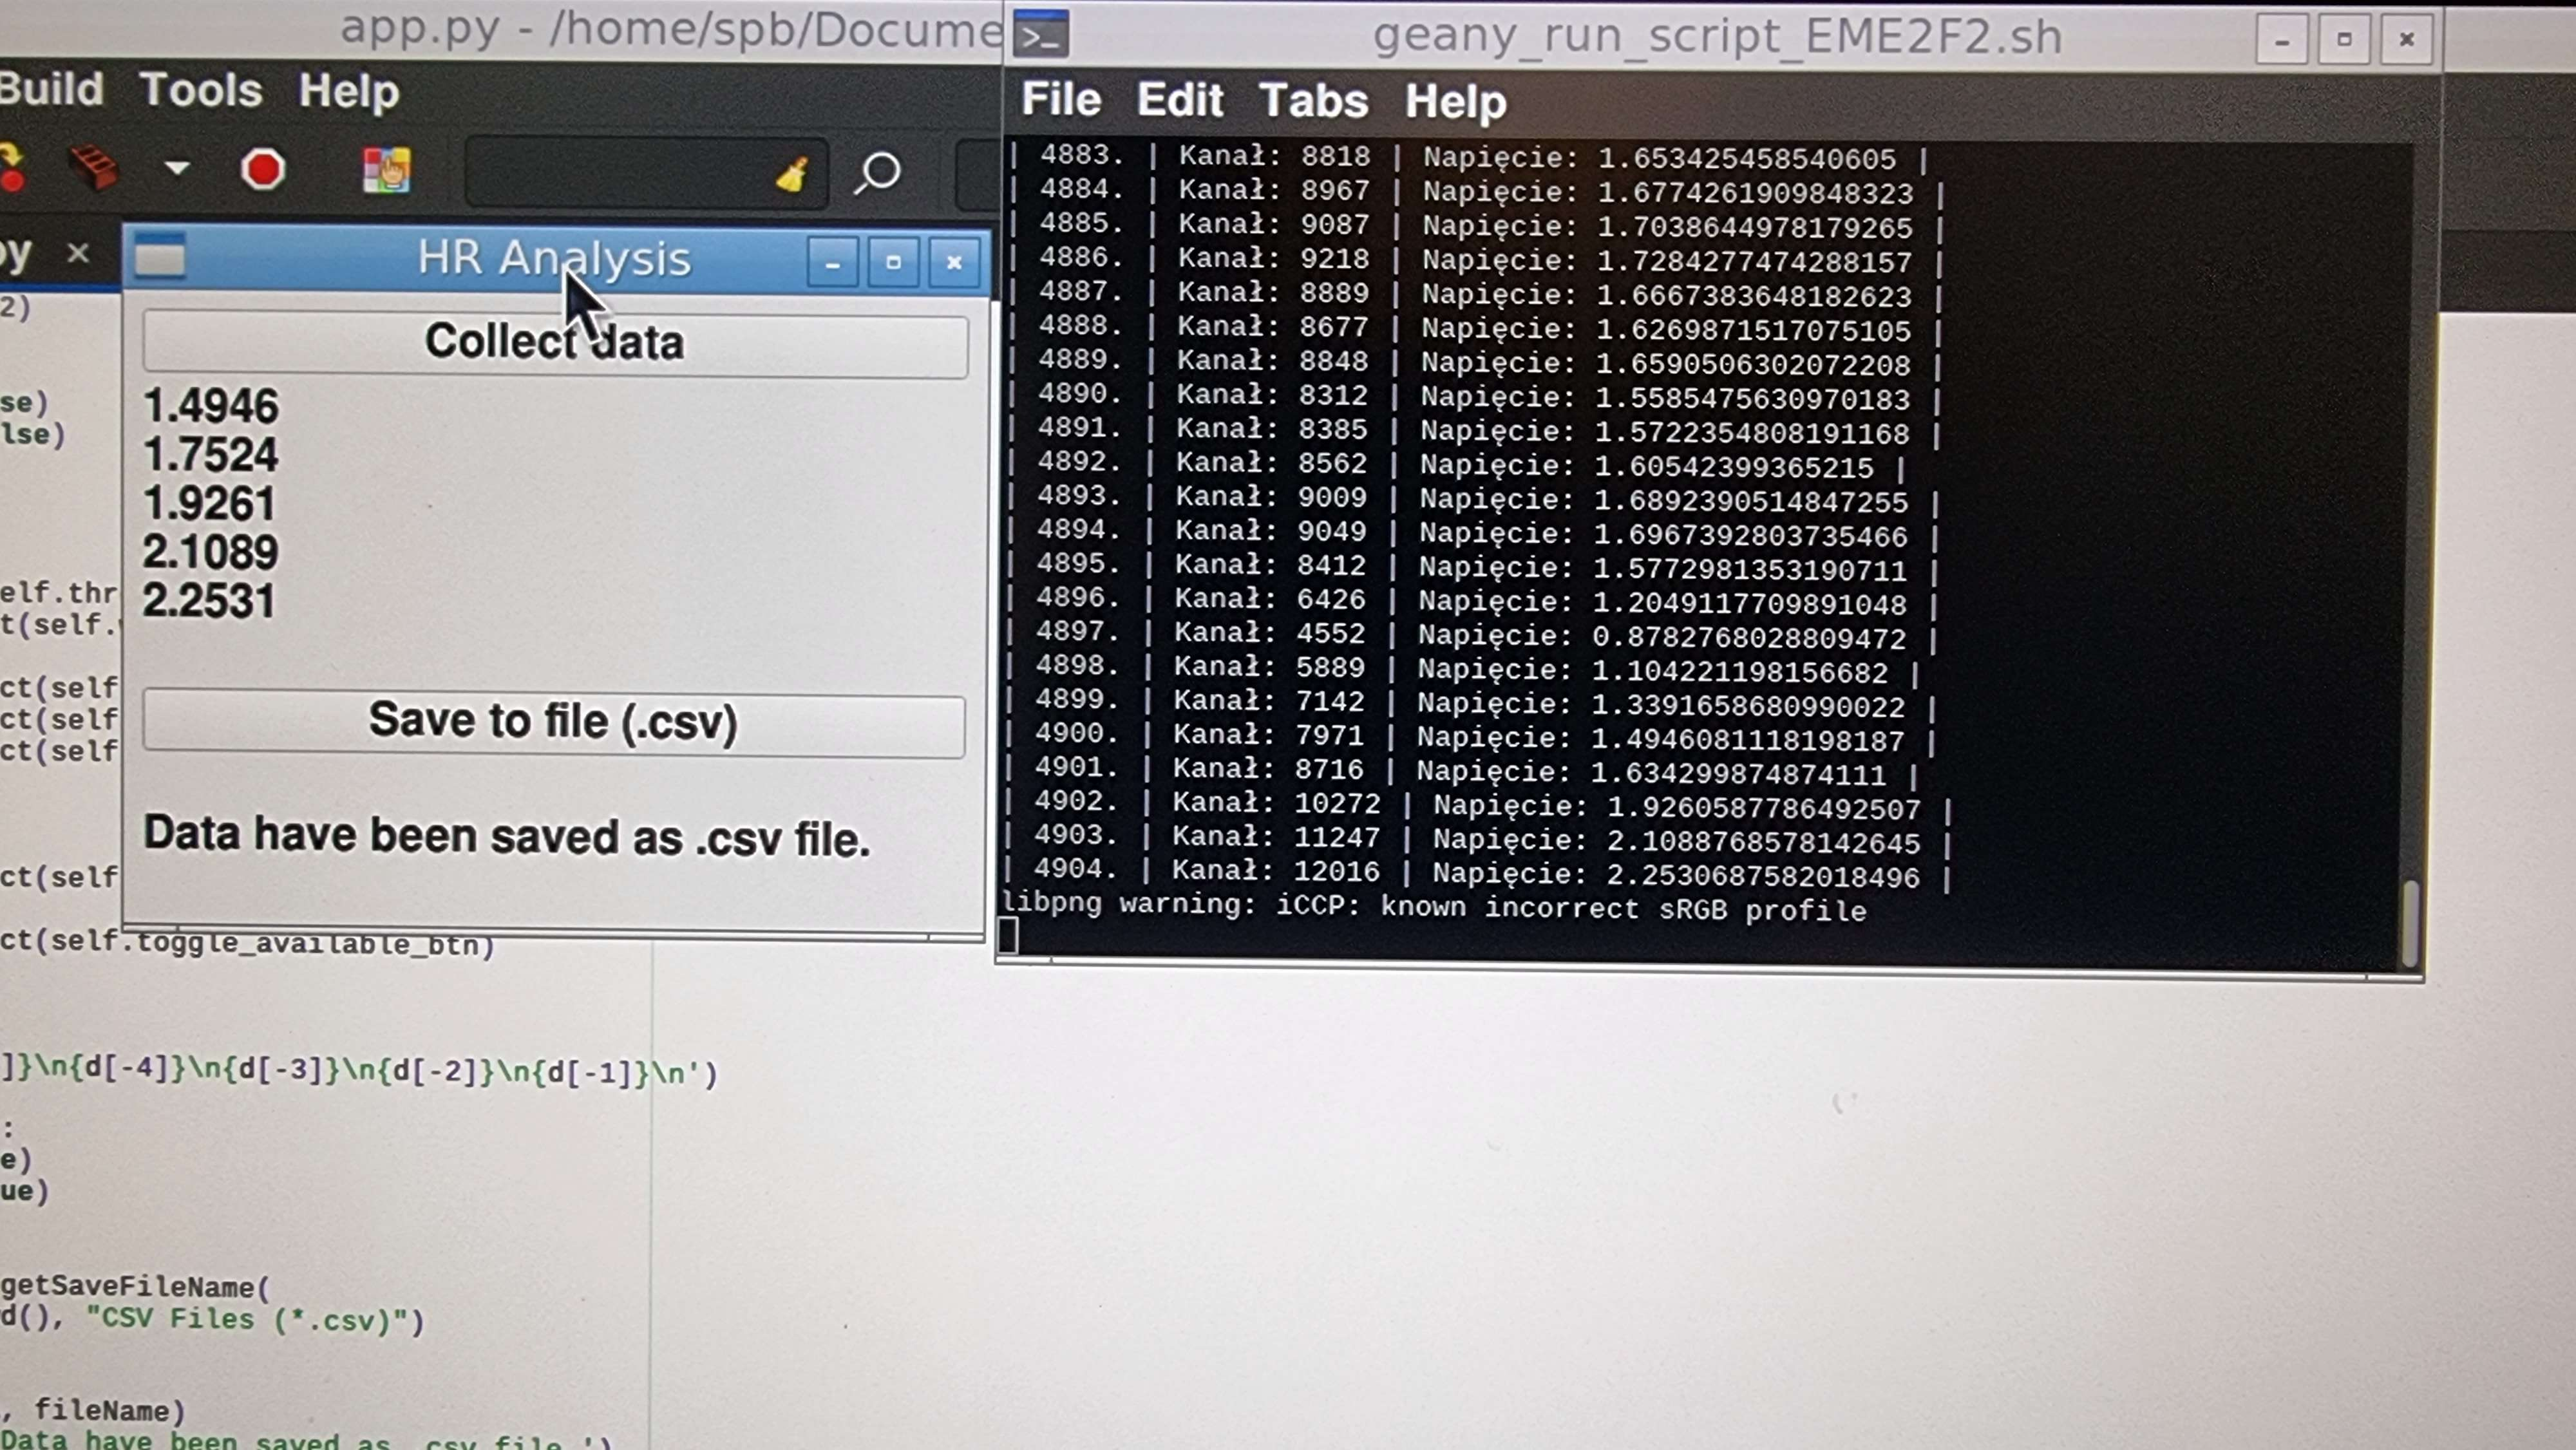


## Opis
W oknie aplikacji rozpoczyna się pomiar (poprzez zastosowanie wątków, okno aplikacji nie zostaje zamrożone na czas pomiaru), natomiast w samej konsoli można zaobserować kolejne wartości kanału i opowiadające im wartości napięć. Po zakończonym pomiarze odblokowana zostaje opcja zapisania zebranych danych do pliku csv. Można również ponowić pomiar. Dzięki zastosowaniu komputera jednoukładowego Raspberry Pi, zapisane pliki można przesłać do komputera za pomocą protokołu SSH, gdzie zostaną poddane dalszej analizie.

Sam sygnał jest próbkowany z częstotliwością $f_s = 100$ Hz, pomiar natomiast trwa $30$ s. Ze względu na opóźnienia na magistrali, rzeczywista ilość próbek jest trochę mniejsza od spodziewanych $3000$ i wynosi ok. $2900$.

## GitHub
Kod źródłowy zarówno aplikacji, jak i funkcji potrzebnych do zbierania danych dostępne są na GitHubie:

https://github.com/StachRach/WristAcousticPulse

# Załadowanie potrzebnych bibliotek, wczytanie danych

In [1912]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fft import fft

In [1913]:
df = pd.DataFrame()
df['Maciek_1'] = pd.read_csv('Pomiary/obiektB.csv', index_col=None)
df['Maciek_2'] = pd.read_csv('Pomiary/obiektB_2.csv', index_col=None)

df['Dorota_1'] = pd.read_csv('Pomiary/obiekt626.csv', index_col=None)
df['Dorota_2'] = pd.read_csv('Pomiary/obiekt626_2.csv', index_col=None)

df['Grzegorz_1'] = pd.read_csv('Pomiary/obiektG.csv', index_col=None)
df['Grzegorz_2'] = pd.read_csv('Pomiary/obiektG_2.csv', index_col=None)

df['Jasmina_1'] = pd.read_csv('Pomiary/obiektJ.csv', index_col=None)
df['Jasmina_2'] = pd.read_csv('Pomiary/obiektJ_2.csv', index_col=None)

df['Patrycja_1'] = pd.read_csv('Pomiary/obiektP.csv', index_col=None)
df['Patrycja_2'] = pd.read_csv('Pomiary/obiektP_2.csv', index_col=None)

df['Mateusz_1'] = pd.read_csv('Pomiary/obiektM.csv', index_col=None)
df['Mateusz_2'] = pd.read_csv('Pomiary/obiektM_2.csv', index_col=None)
df['Mateusz_3'] = pd.read_csv('Pomiary/obiektM_3.csv', index_col=None)
df['Mateusz_4'] = pd.read_csv('Pomiary/obiektM_4.csv', index_col=None)
df['Mateusz_5'] = pd.read_csv('Pomiary/obiektM_5.csv', index_col=None)

df['Staszek_1'] = pd.read_csv('Pomiary/obiektS.csv', index_col=None)
df['Staszek_2'] = pd.read_csv('Pomiary/obiektS_2.csv', index_col=None)
df['Staszek_3'] = pd.read_csv('Pomiary/obiektS_3.csv', index_col=None)
df['Staszek_4'] = pd.read_csv('Pomiary/obiektS_4.csv', index_col=None)
df['Staszek_5'] = pd.read_csv('Pomiary/obiektS_5.csv', index_col=None)

df = df.fillna(method='ffill')

/tmp/ipykernel_6262/2936714347.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [1914]:
df.head()

Maciek_1  Maciek_2  Dorota_1  Dorota_2  Grzegorz_1  Grzegorz_2  Jasmina_1  \
0    1.4144    1.5220    1.7719    1.2934      1.7924      1.6495     1.5734   
1    1.5216    1.5210    1.7453    1.2460      1.8162      1.6529     1.5615   
2    1.6604    1.5317    1.7648    1.2392      1.7950      1.6457     1.5559   
3    1.7102    1.5522    1.7954    1.3365      1.7654      1.6435     1.5687   
4    1.7519    1.5782    1.8379    1.4181      1.7367      1.6501     1.5914   

   Jasmina_2  Patrycja_1  Patrycja_2  Mateusz_1  Mateusz_2  Mateusz_3  \
0     1.7614      1.6285      1.6262     1.7704     1.6546     1.6606   
1     1.8036      1.6681      1.6441     1.7206     1.5917     1.6380   
2     1.7755      1.6639      1.6289     1.7014     1.5764     1.6047   
3     1.7363      1.6988      1.6285     1.7234     1.5769     1.6028   
4     1.7110      1.7432      1.6424     1.7311     1.5062     1.6887   

   Mateusz_4  Mateusz_5  Staszek_1  Staszek_2  Staszek_3  Staszek_4  Staszek_5  
0     1.5870     1.6418     1.6067     1.6641     1.6784     1.5533     1.1912  
1     1.8025     1.5919     1.5794     1.6660     1.6632     1.5664     1.4417  
2     2.0277     1.4612     1.5915     1.6546     1.6512     1.5897     1.6982  
3     2.3144     0.7000     1.6127     1.6221     1.6446     1.6157     1.8353  
4     2.3320     0.0516     1.6341     1.6182     1.6555     1.6339     1.9056

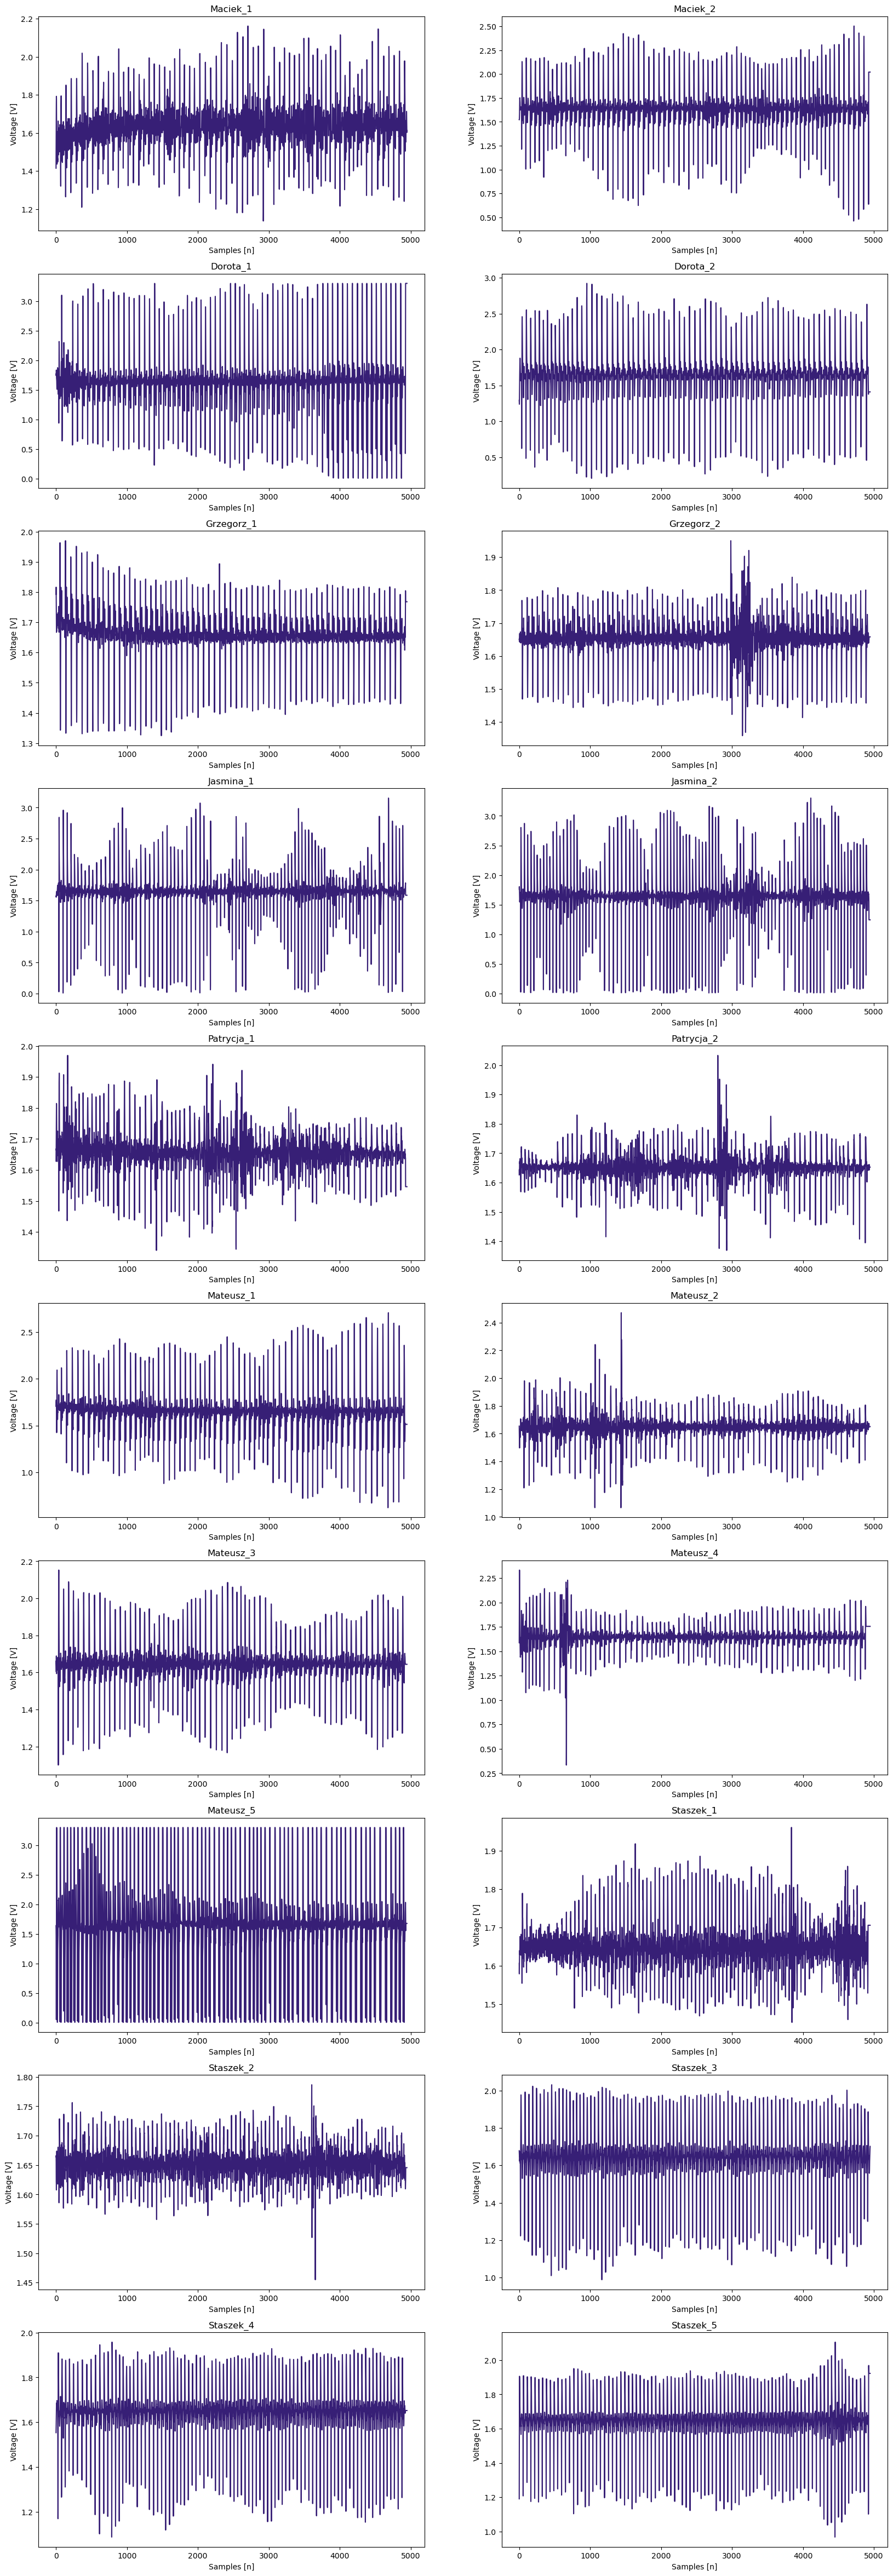

In [1915]:
fig, axs = plt.subplots(10, 2, figsize=(20, 60))

for i in range(10):
    for j in range(2):
        axs[i, j].plot(df[df.columns[i*2+j]], color='#371F76')
        axs[i, j].set_title(df.columns[i*2+j])
        axs[i, j].set_xlabel('Samples [n]')
        axs[i, j].set_ylabel('Voltage [V]')

plt.show()

# Definicje:
Na potrzeby skryptu zdefiniowano: 

 - funkcję normalizującą dane, 
 - filtr pasmowo-przepustowy (BPF).

In [1916]:
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

In [1917]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Definicje odpowiednich parametrów oraz preprocessing
Poniżej ustawiono częstotliwości odcięcia (dolną i górną), jak i częstotliwość próbkowania.

Po normalizacji danych zastosowano na nich filtr pasmowo-przepustowy. Tak przerobione dane poddano średniej krączącej, w celu znalezienia poszczególnych średnich wartości szczytowych sygnału.

In [1918]:
lowcut = 0.1  # Lower cutoff frequency in Hz
highcut = 25.0  # Upper cutoff frequency in Hz
sampling_rate = 100  # Sample rate in Hz

df = normalize_signal(df)

/home/staszek/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [1919]:
df.columns

Index(['Maciek_1', 'Maciek_2', 'Dorota_1', 'Dorota_2', 'Grzegorz_1',
       'Grzegorz_2', 'Jasmina_1', 'Jasmina_2', 'Patrycja_1', 'Patrycja_2',
       'Mateusz_1', 'Mateusz_2', 'Mateusz_3', 'Mateusz_4', 'Mateusz_5',
       'Staszek_1', 'Staszek_2', 'Staszek_3', 'Staszek_4', 'Staszek_5'],
      dtype='object')

# Wyświetlenie sygnału

# Analiza częstotliwościowa sygnału (FFT)
Na widmie częstotliwościowym widać poszczególne harmoniczne sygnału. Można również stwierdzić prawidłowe działanie filtru pasmowo-przepustowego.

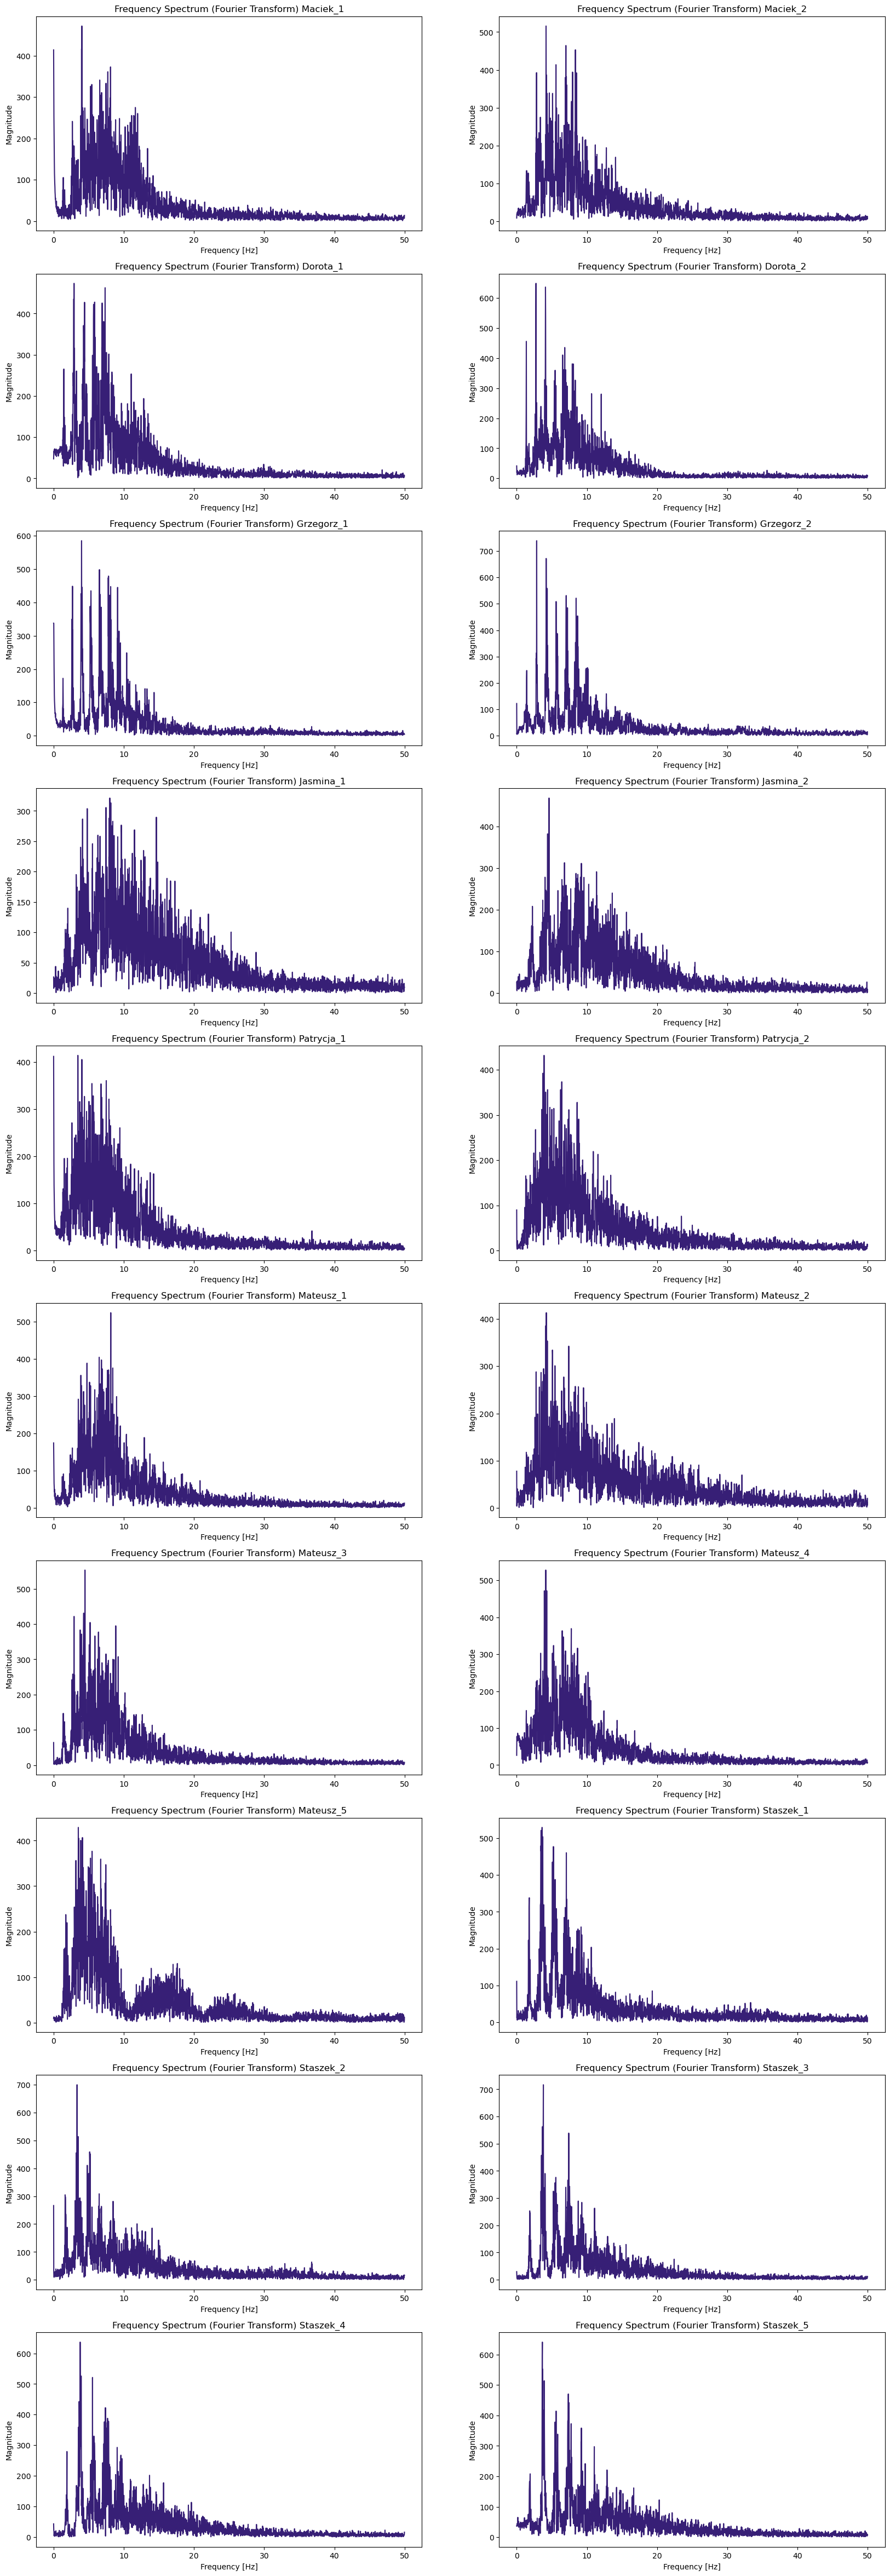

In [1920]:
fig, axs = plt.subplots(10, 2, figsize=(20, 60))

for i in range(10):
    for j in range(2):
        frequencies = np.fft.fftfreq(len(df[df.columns[i * 2 + j]]), d=1 / sampling_rate)

        fft_values = np.fft.fft(df[df.columns[i * 2 + j]])
        magnitude_spectrum = np.abs(fft_values)

        axs[i, j].plot(frequencies[:len(frequencies) // 2], magnitude_spectrum[:len(magnitude_spectrum) // 2], color='#371F76')
        axs[i, j].set_title('Frequency Spectrum (Fourier Transform) ' + df.columns[i * 2 + j])
        axs[i, j].set_xlabel('Frequency [Hz]')
        axs[i, j].set_ylabel('Magnitude')

# Wyliczenie HR

## Metoda

W tym podejściu nie zastosowano średniej krączącej, wyznaczono jedynie kolejne wartości szczytowe.


In [2212]:

def analyze_pulse(signal, sampling_rate):

    normalized_signal = normalize_signal(signal)

    mean_amp = np.mean(normalized_signal)
    std_amp = np.std(normalized_signal)
    
    height_threshold = mean_amp + 1.4 *std_amp

    peaks, _ = find_peaks(normalized_signal, height= height_threshold)

    heart_rate = peaks.size

    plt.figure(figsize=(15, 6))

    plt.plot(normalized_signal, label='Signal', color='#371F76')
    plt.title(f'Pulse Signal Analysis  {df.columns[i * 2 + j]}')
    plt.xlabel('Index (Sample Number)')
    return heart_rate, peaks

In [2213]:
def plot_signal_with_peaks(signal, peaks, y_label):
    plt.figure(figsize=(10, 6))
    plt.plot(signal, label='Signal', color='#371F76')
    plt.plot(peaks, signal.iloc[peaks], 'r.', label='Pulse Peaks')
    plt.title('Pulse Signal Analysis')
    plt.xlabel('Index (Sample Number)')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

Heart Rate for Maciek_1: 76 beats per minute


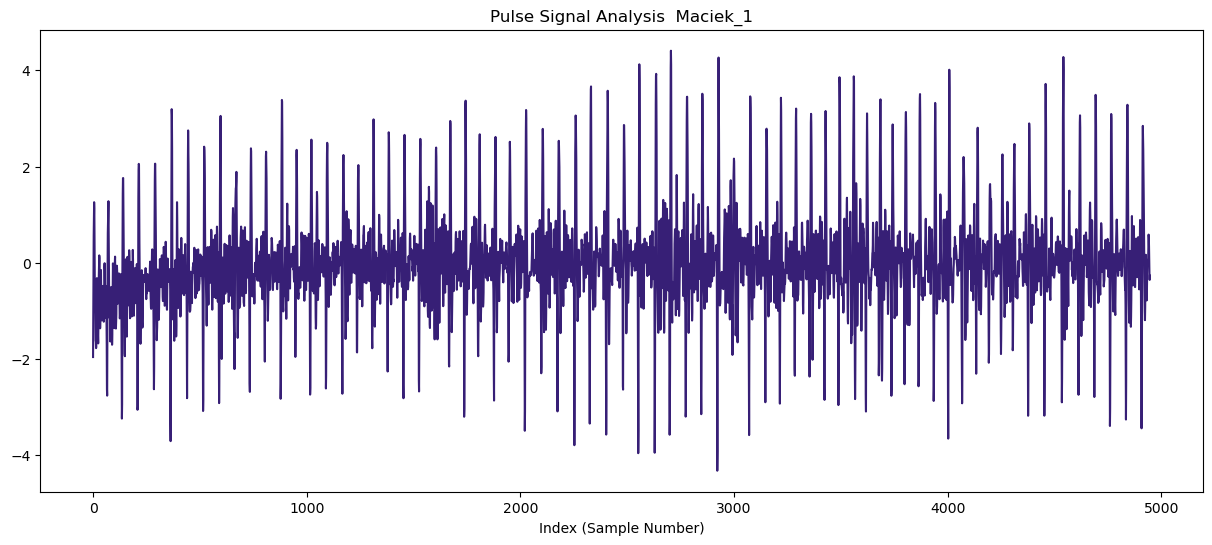

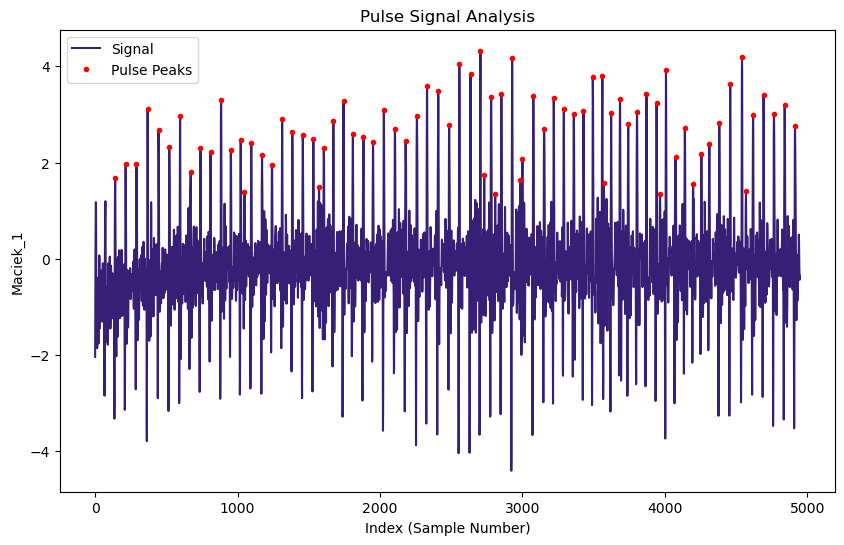

Heart Rate for Maciek_2: 75 beats per minute


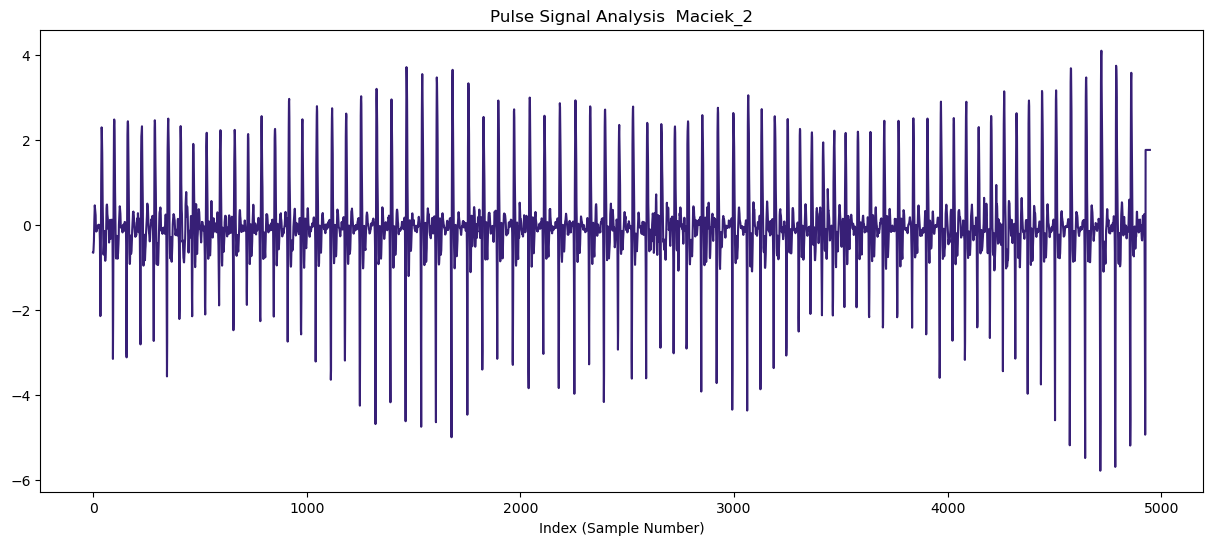

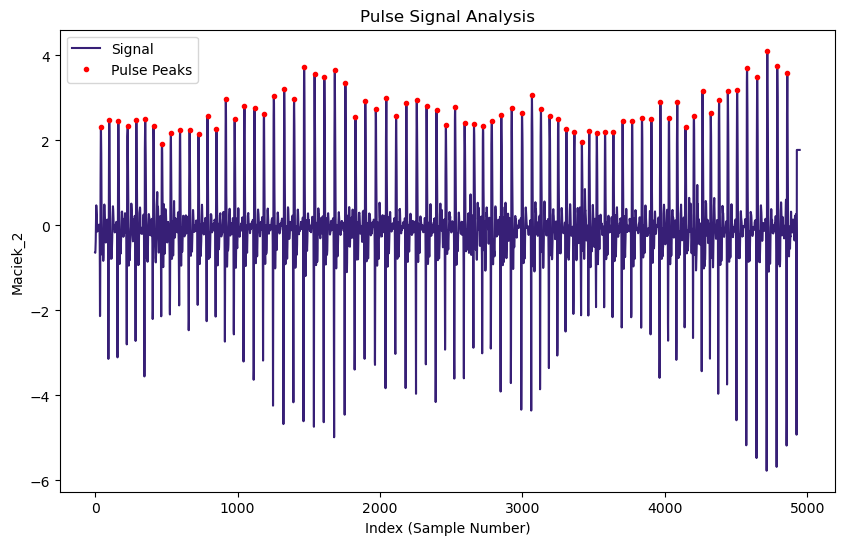

Heart Rate for Dorota_1: 69 beats per minute


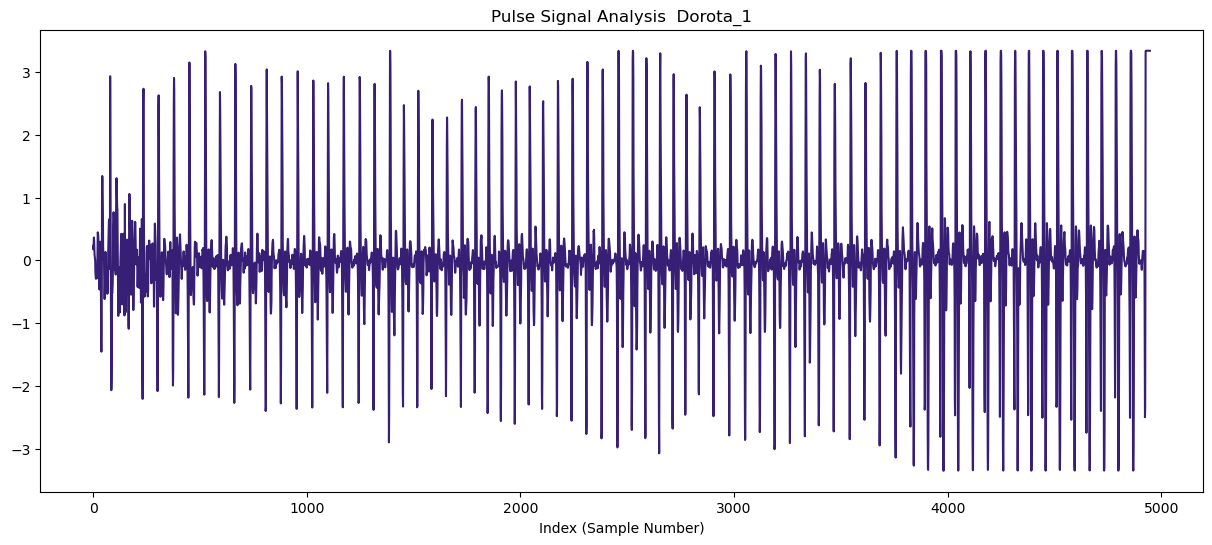

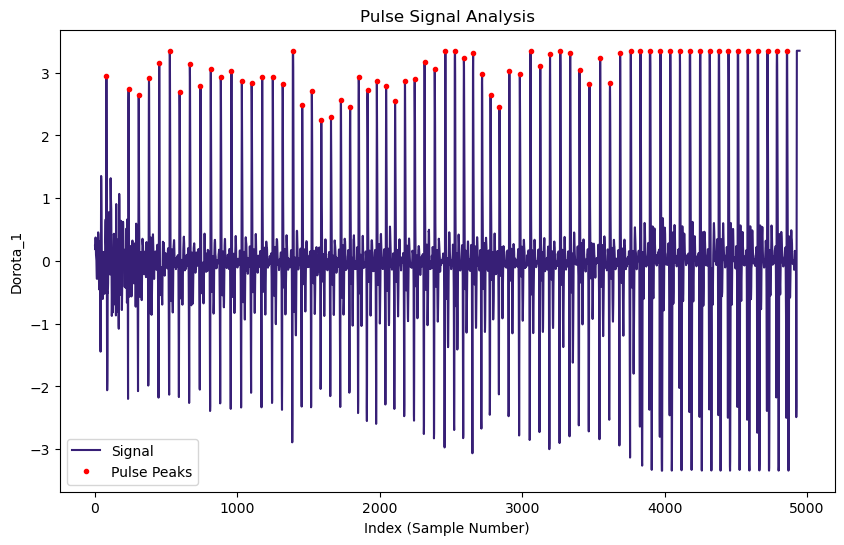

Heart Rate for Dorota_2: 70 beats per minute


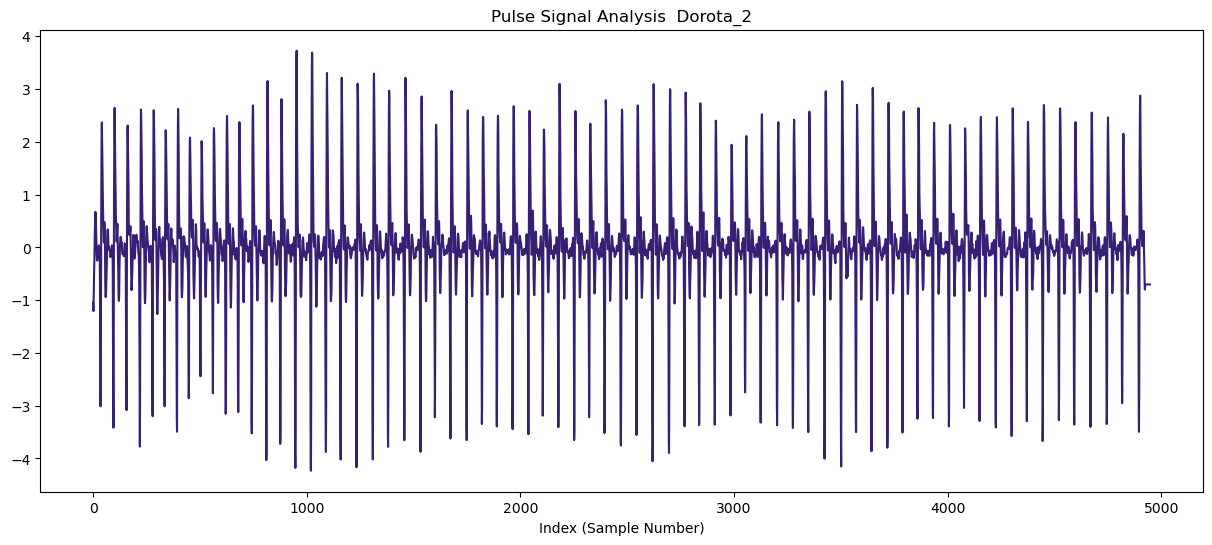

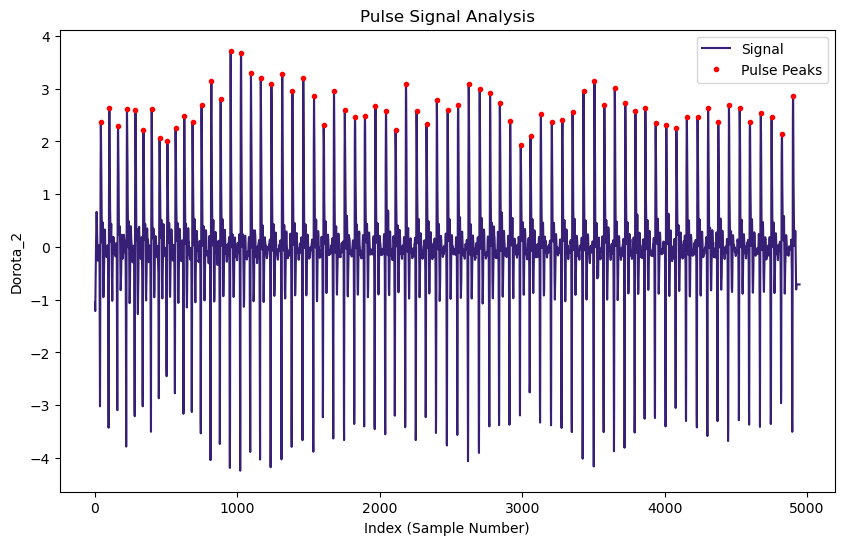

Heart Rate for Grzegorz_1: 81 beats per minute


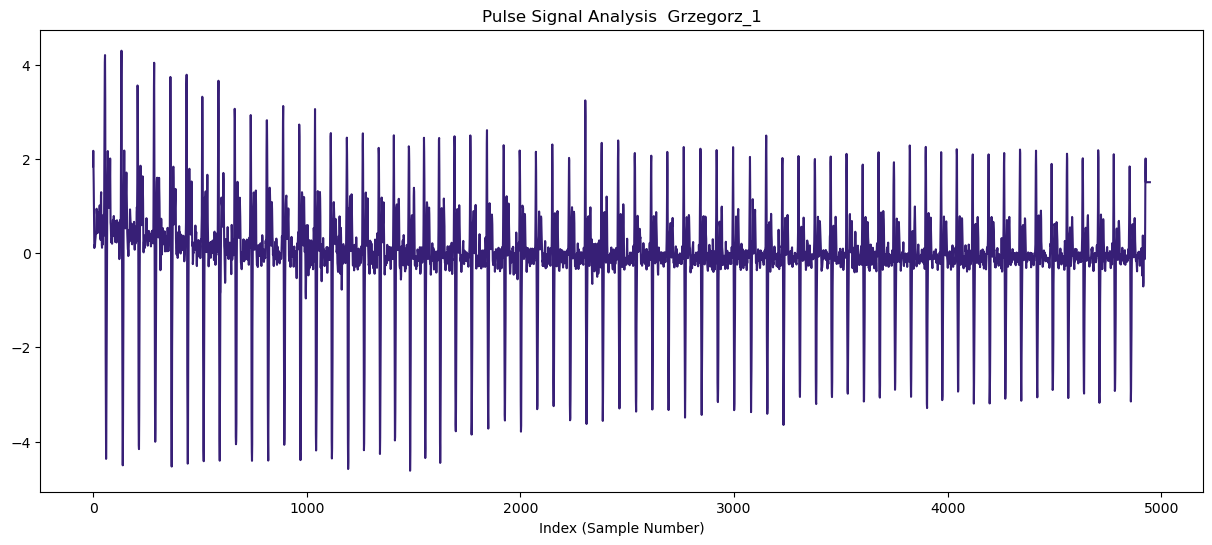

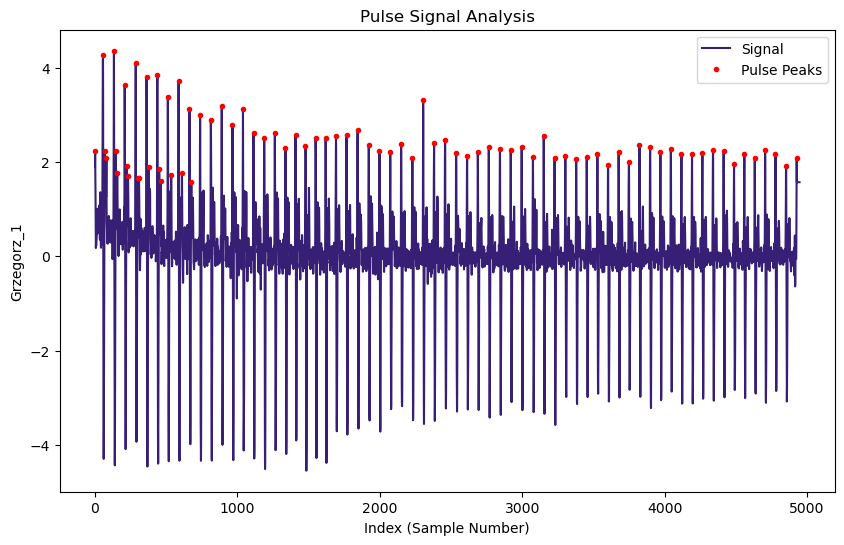

Heart Rate for Grzegorz_2: 97 beats per minute


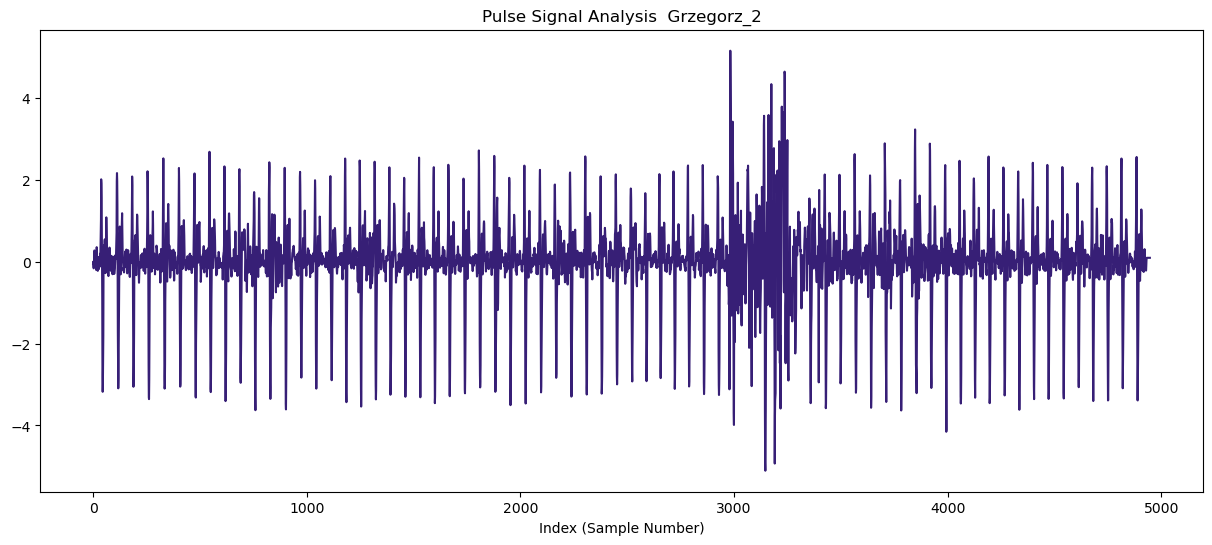

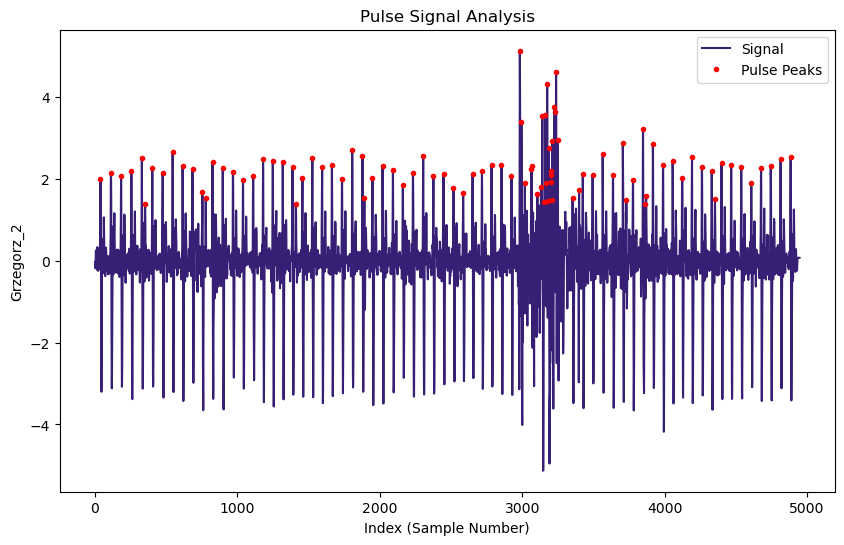

Heart Rate for Jasmina_1: 65 beats per minute


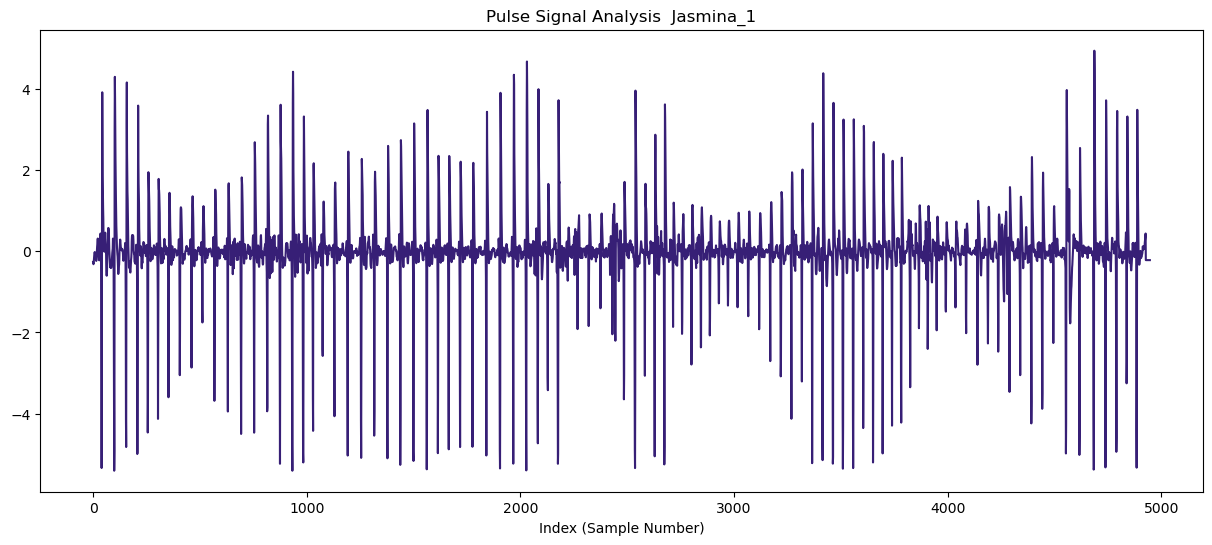

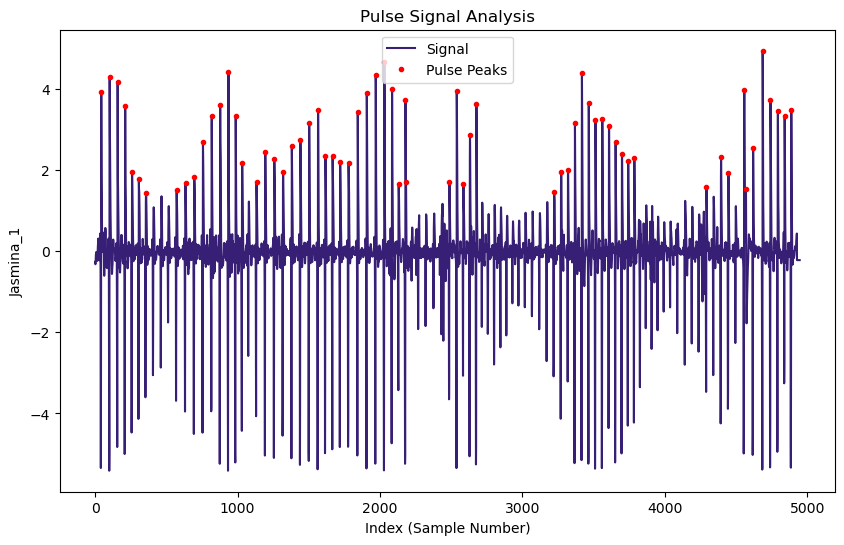

Heart Rate for Jasmina_2: 81 beats per minute


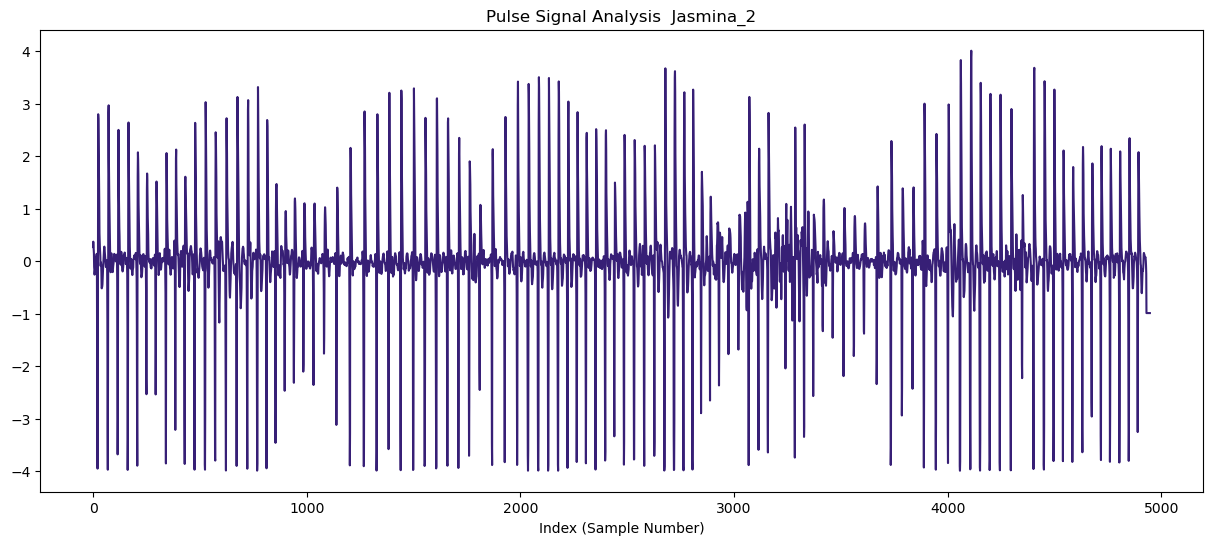

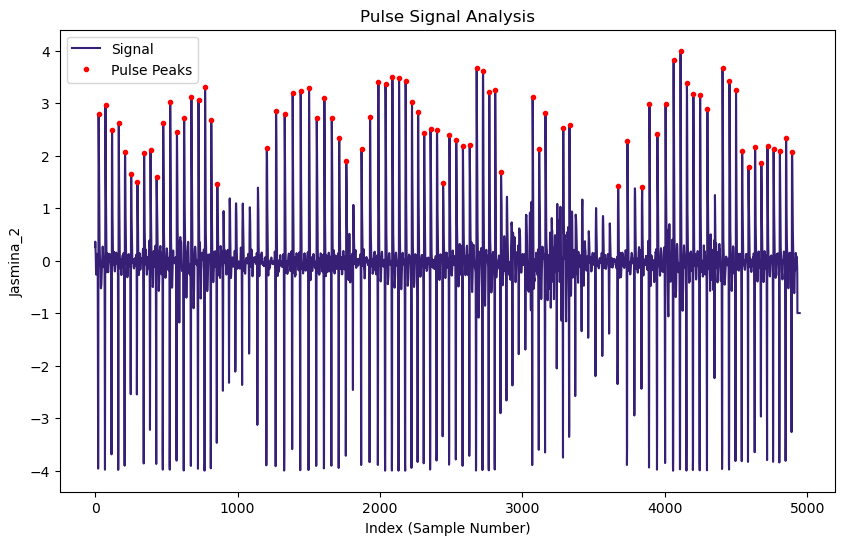

Heart Rate for Patrycja_1: 89 beats per minute


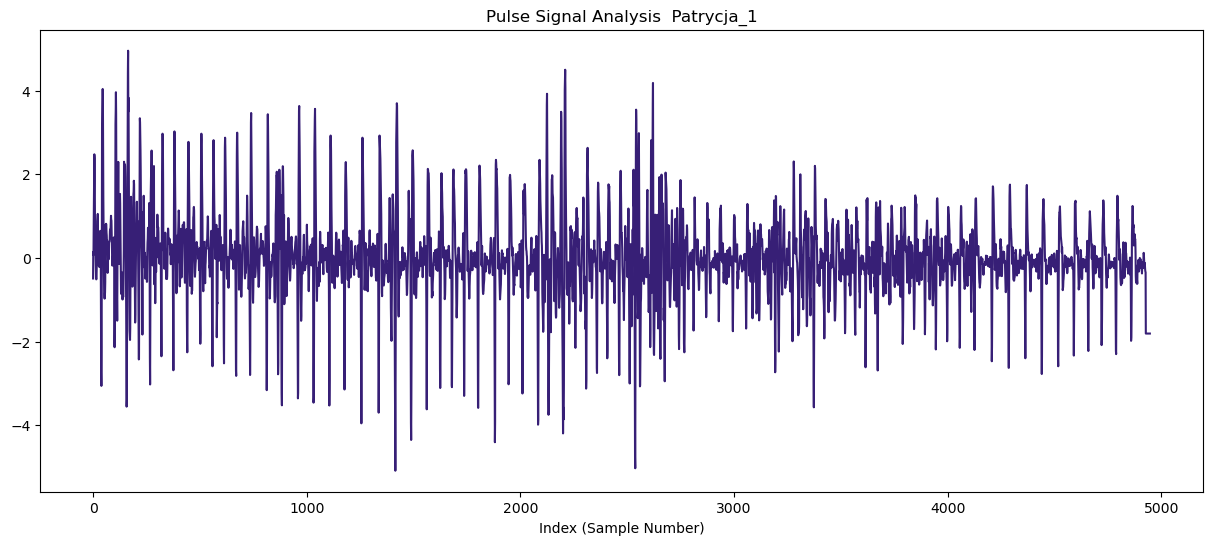

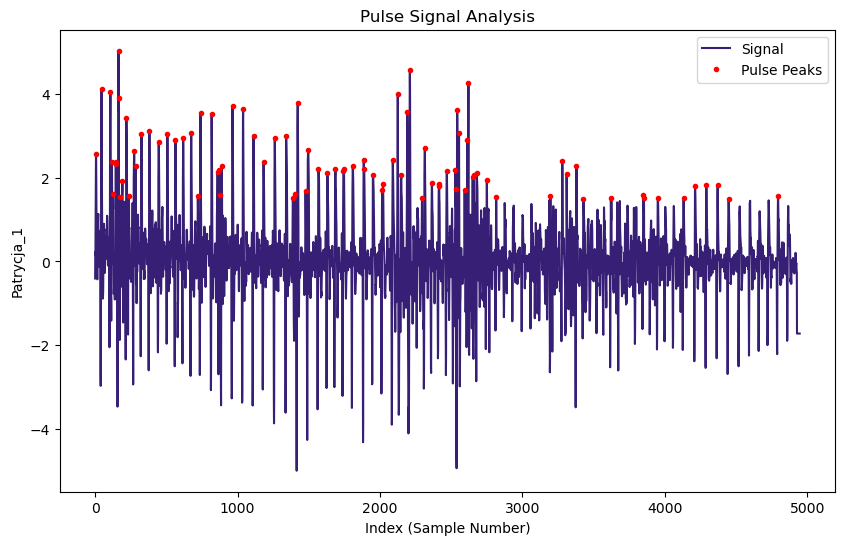

Heart Rate for Patrycja_2: 93 beats per minute


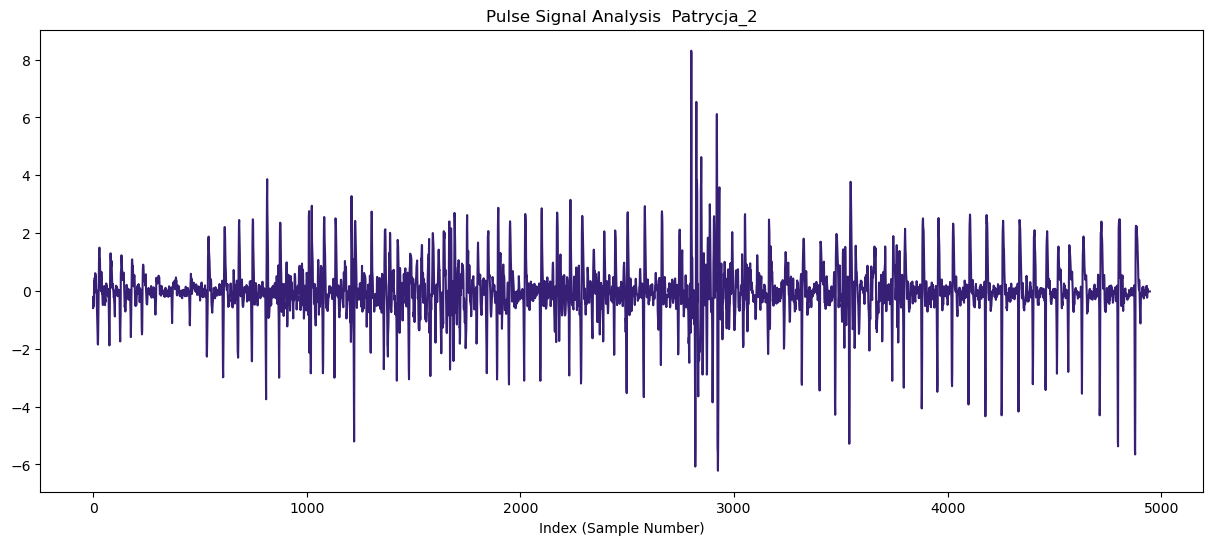

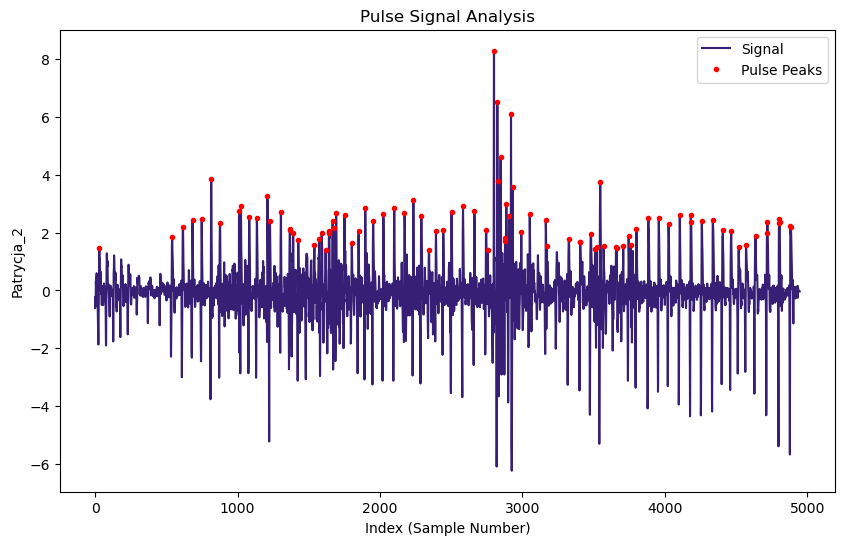

Heart Rate for Mateusz_1: 69 beats per minute


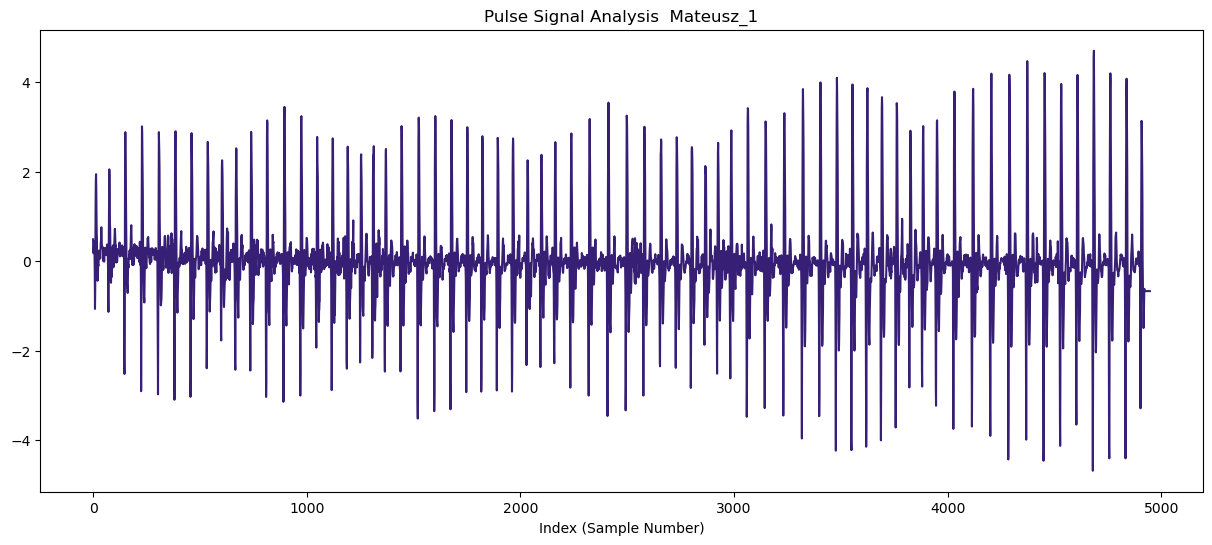

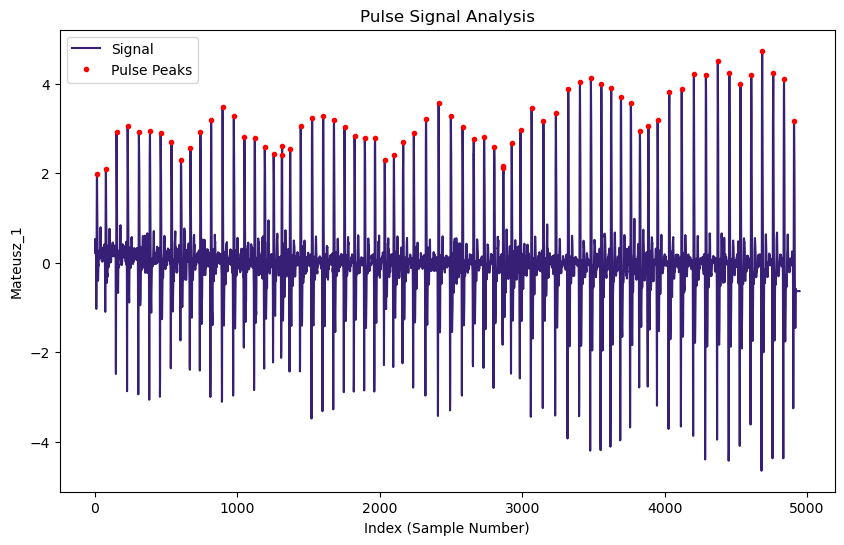

Heart Rate for Mateusz_2: 95 beats per minute


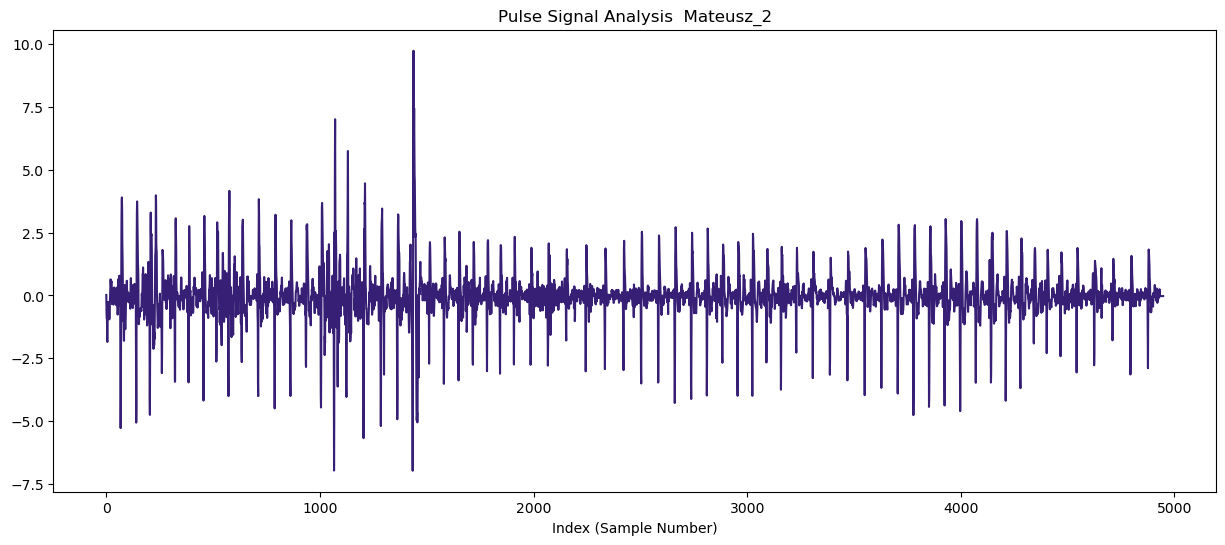

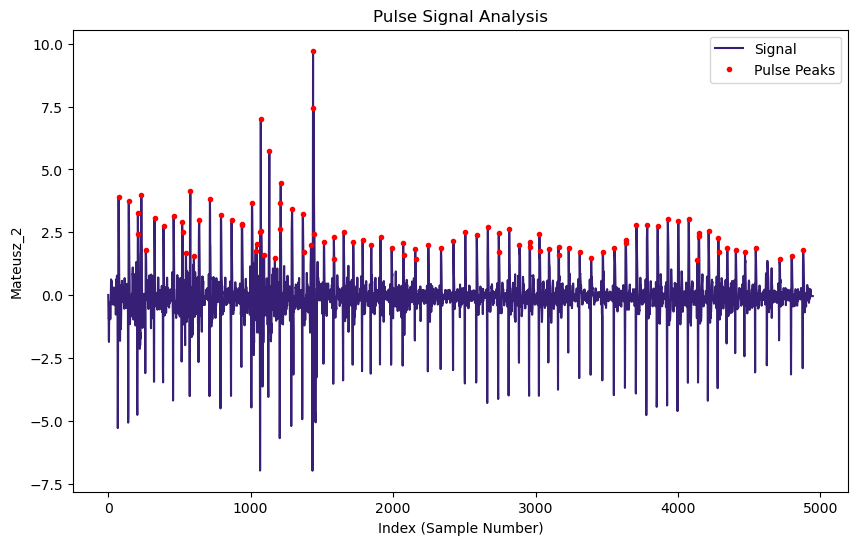

Heart Rate for Mateusz_3: 70 beats per minute


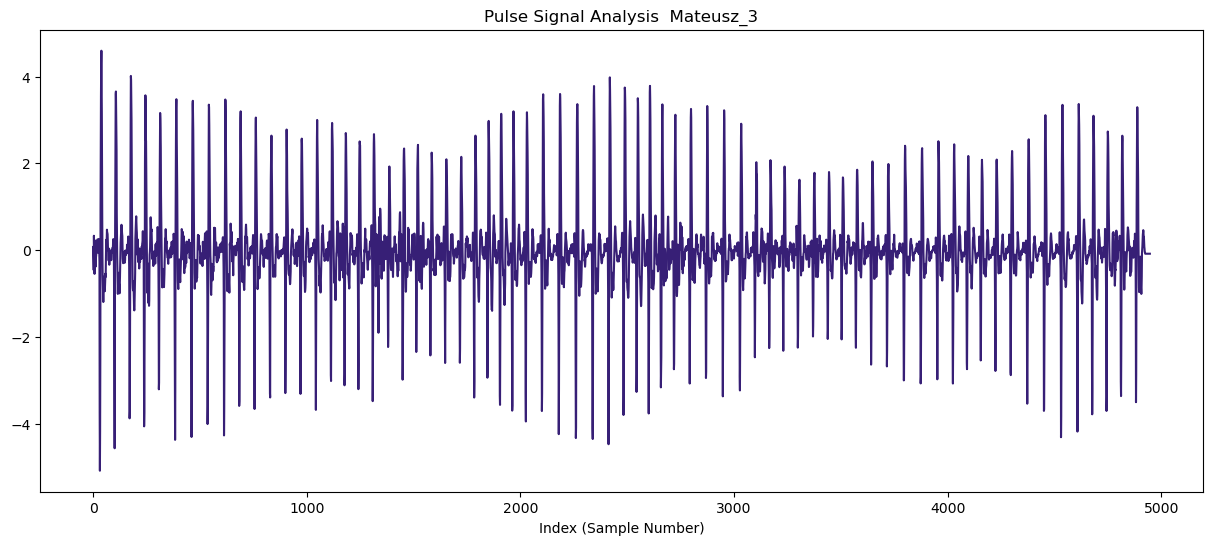

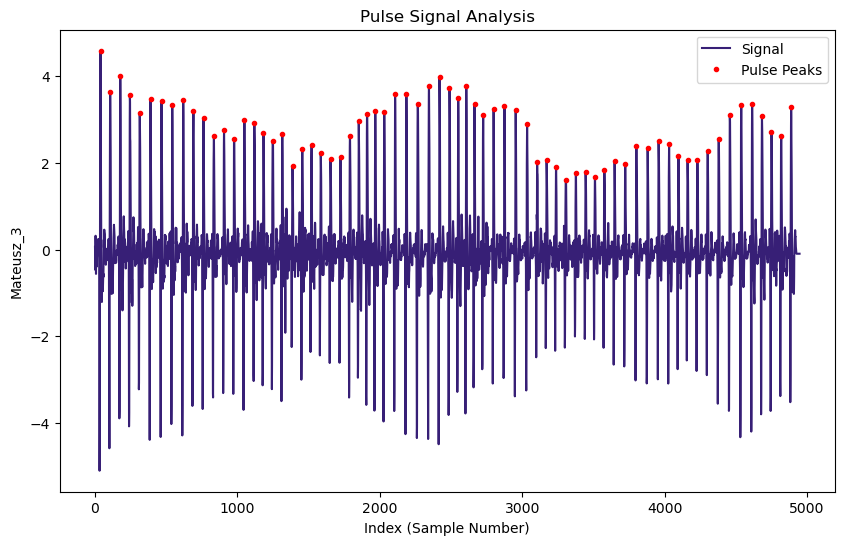

Heart Rate for Mateusz_4: 75 beats per minute


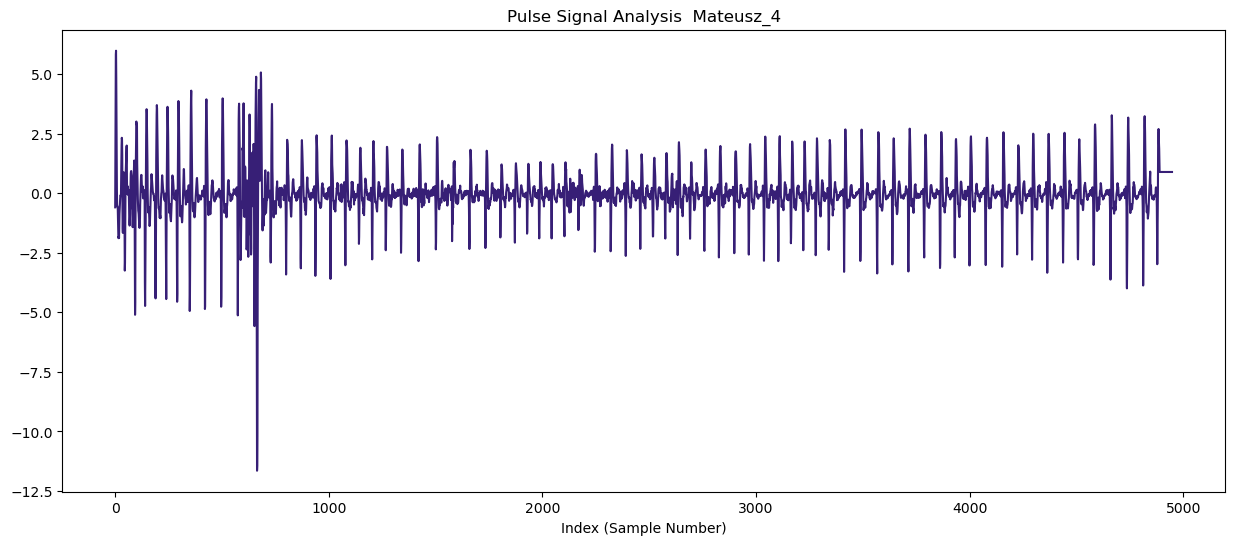

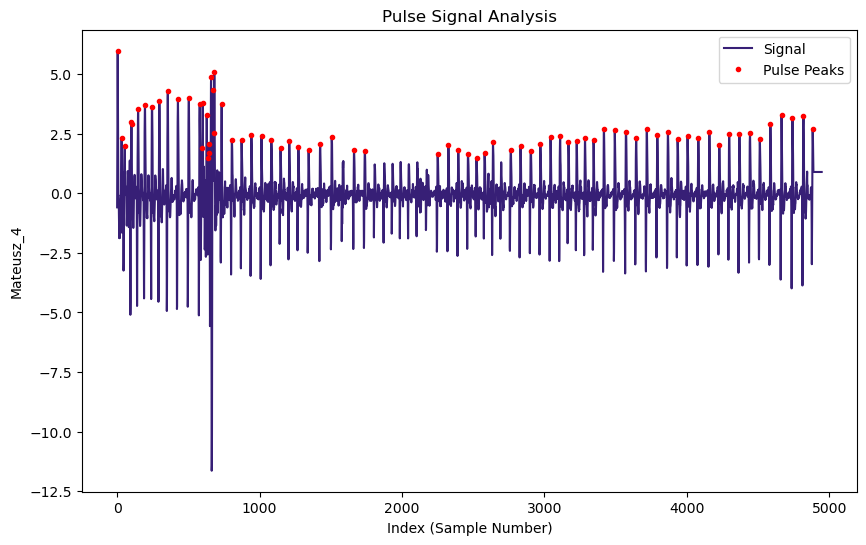

Heart Rate for Mateusz_5: 90 beats per minute


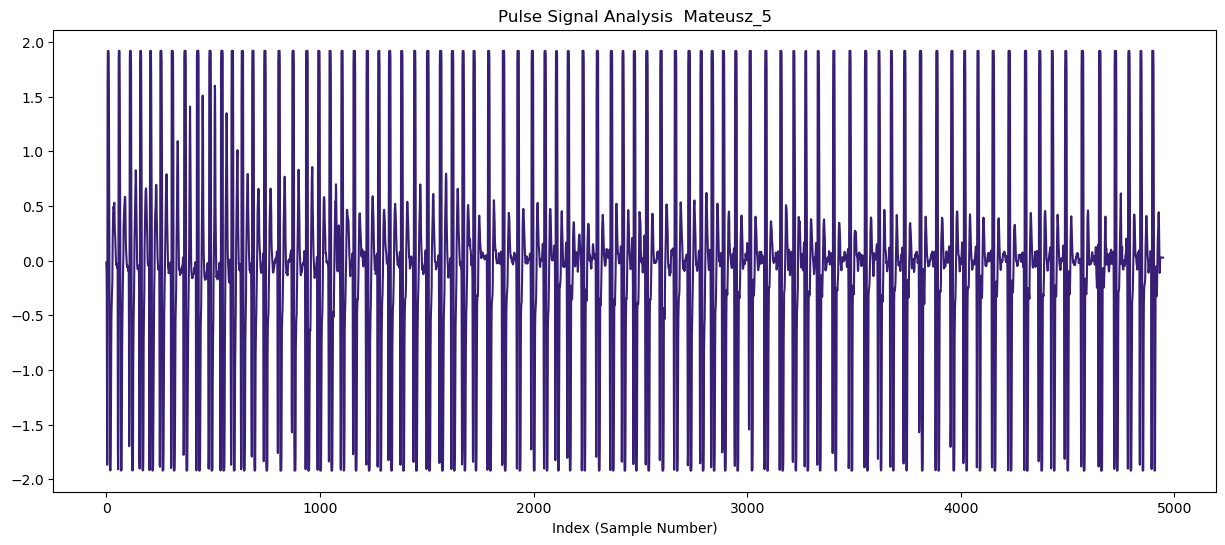

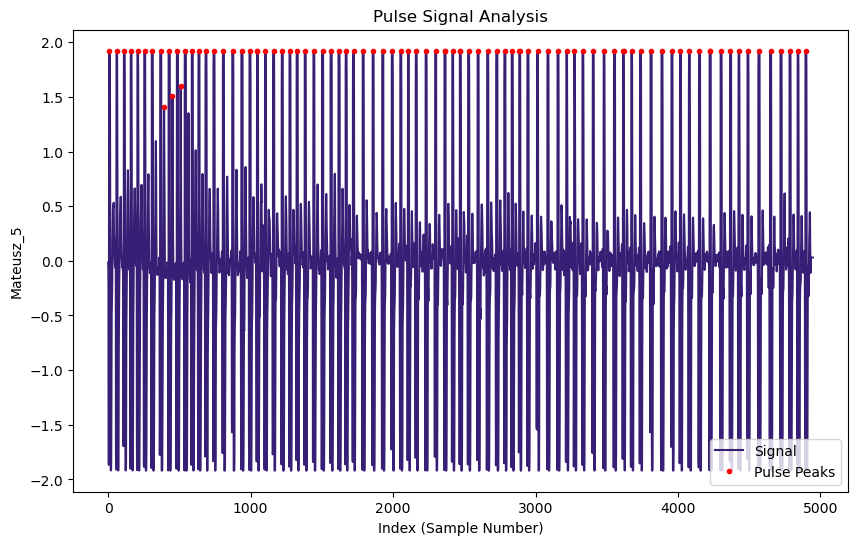

Heart Rate for Staszek_1: 92 beats per minute


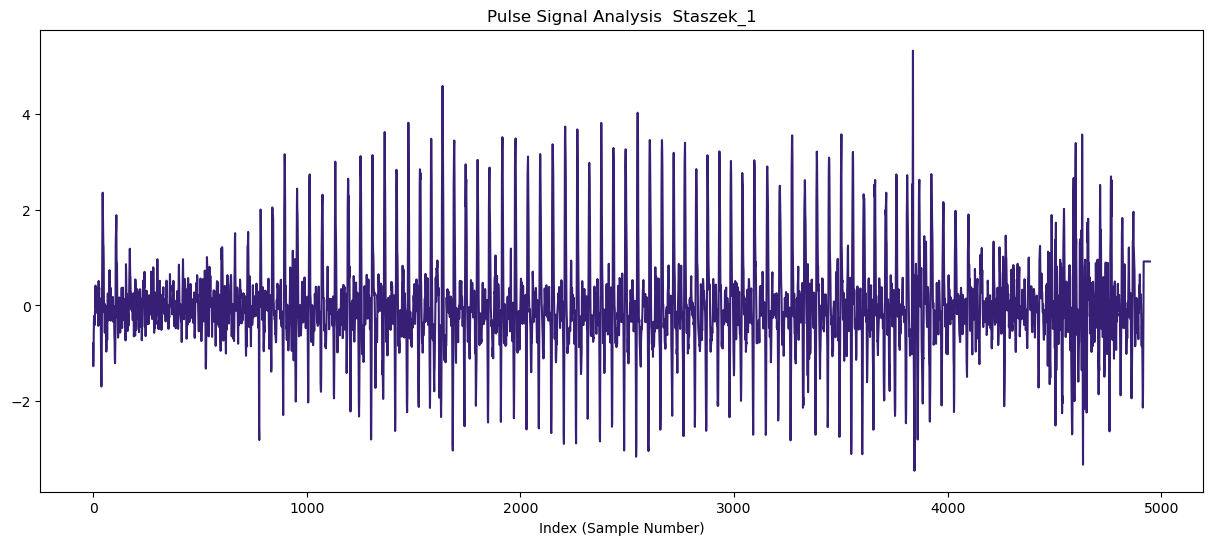

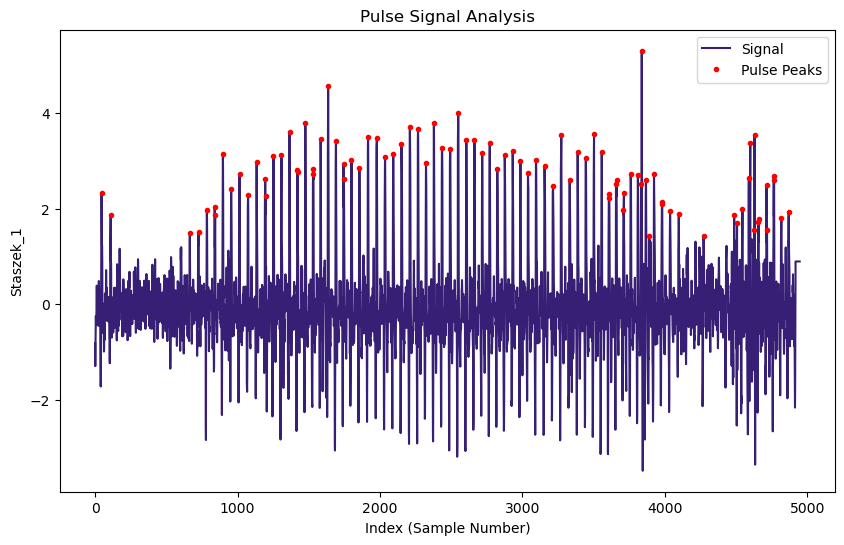

Heart Rate for Staszek_2: 137 beats per minute


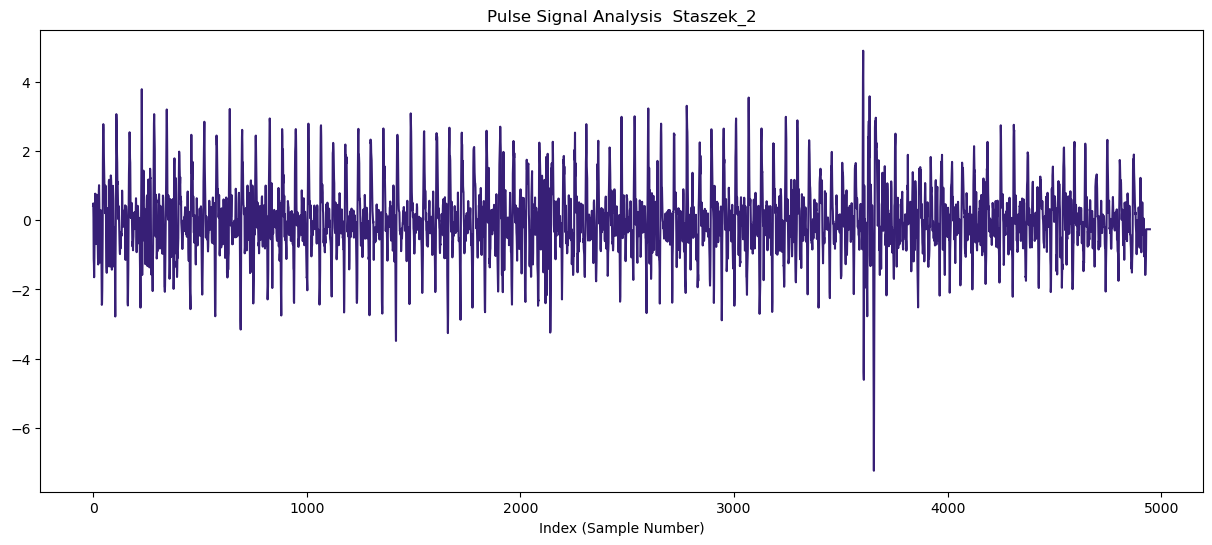

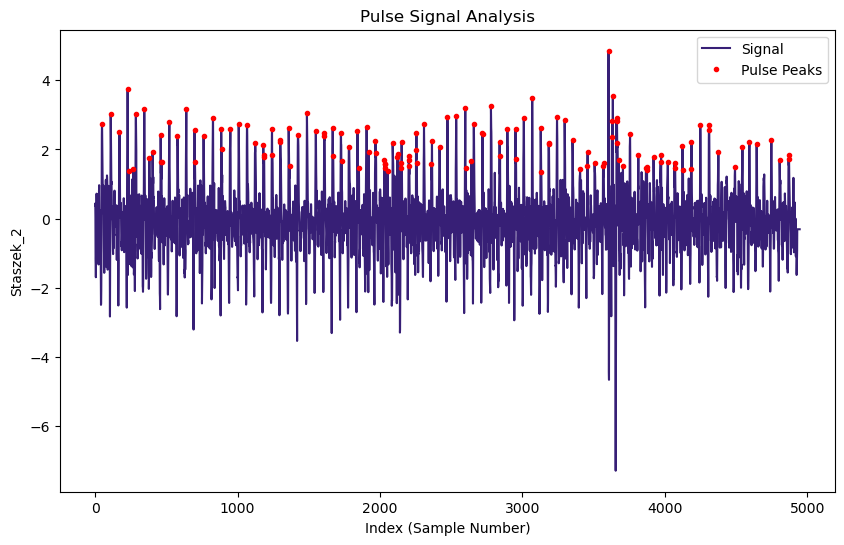

Heart Rate for Staszek_3: 92 beats per minute


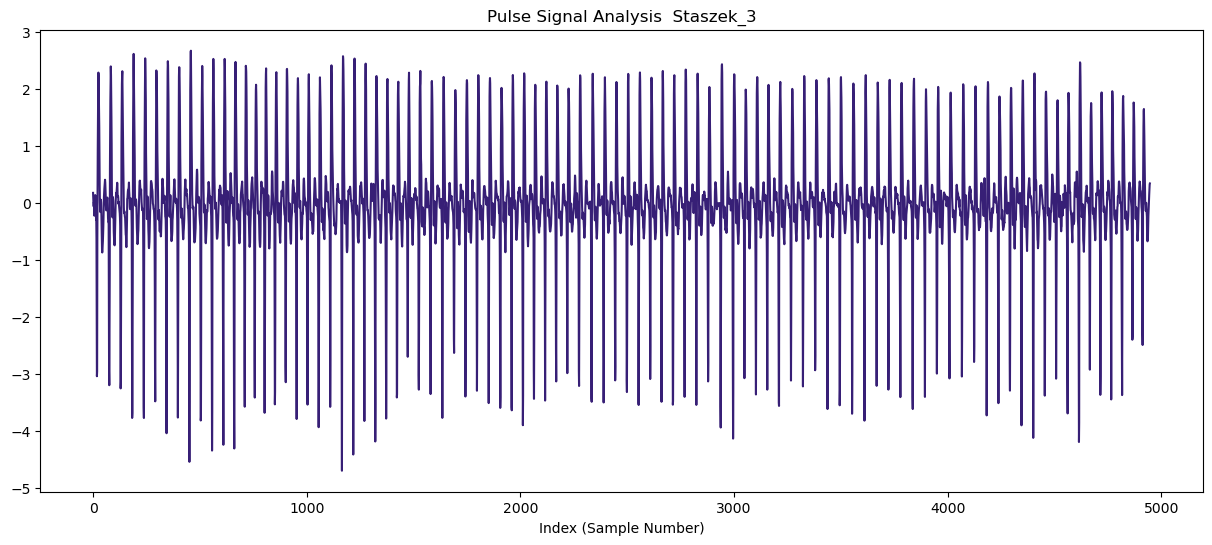

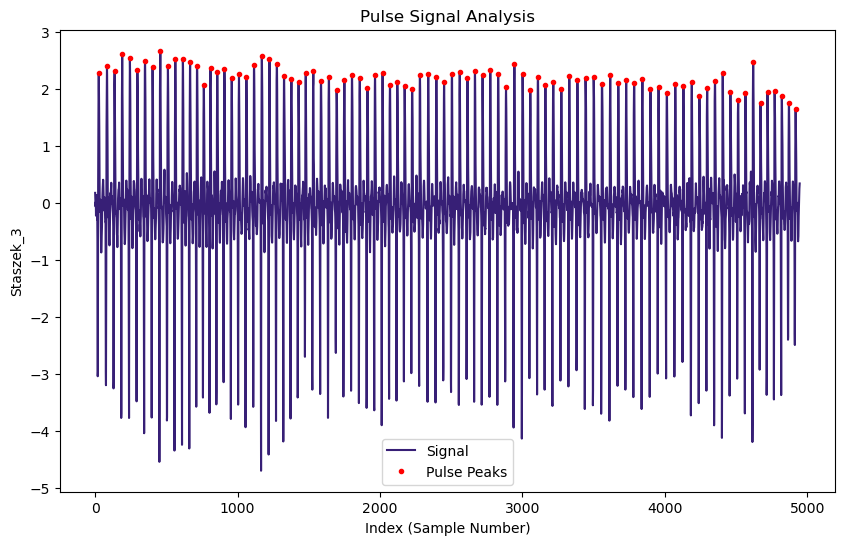

Heart Rate for Staszek_4: 91 beats per minute


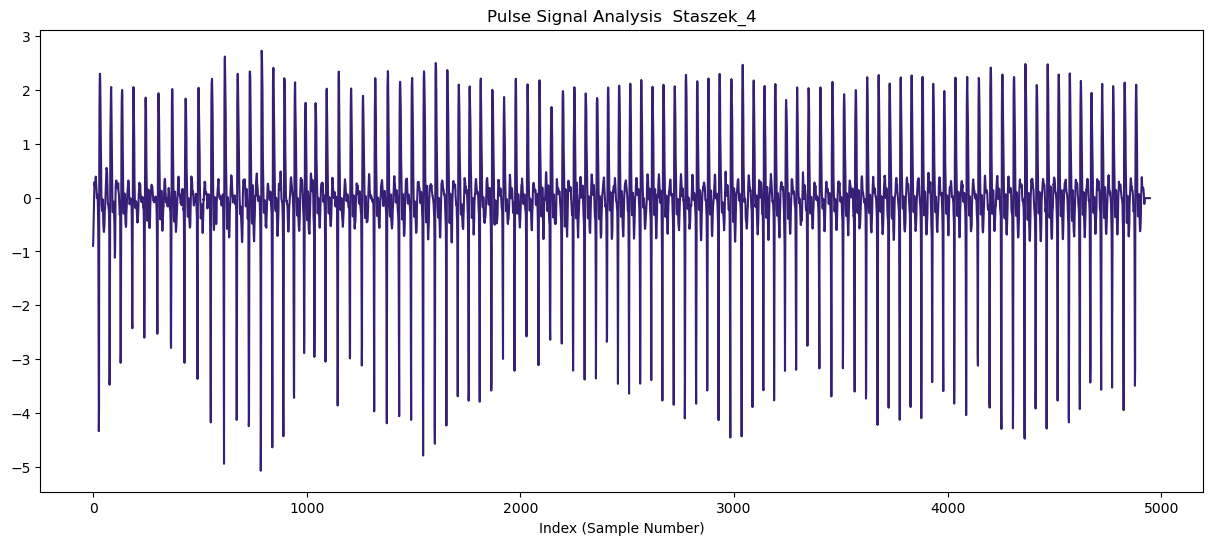

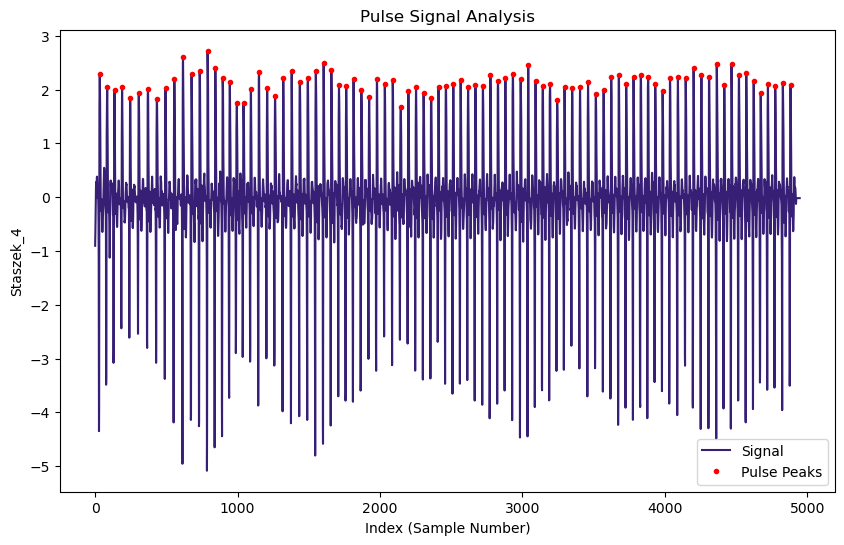

Heart Rate for Staszek_5: 95 beats per minute


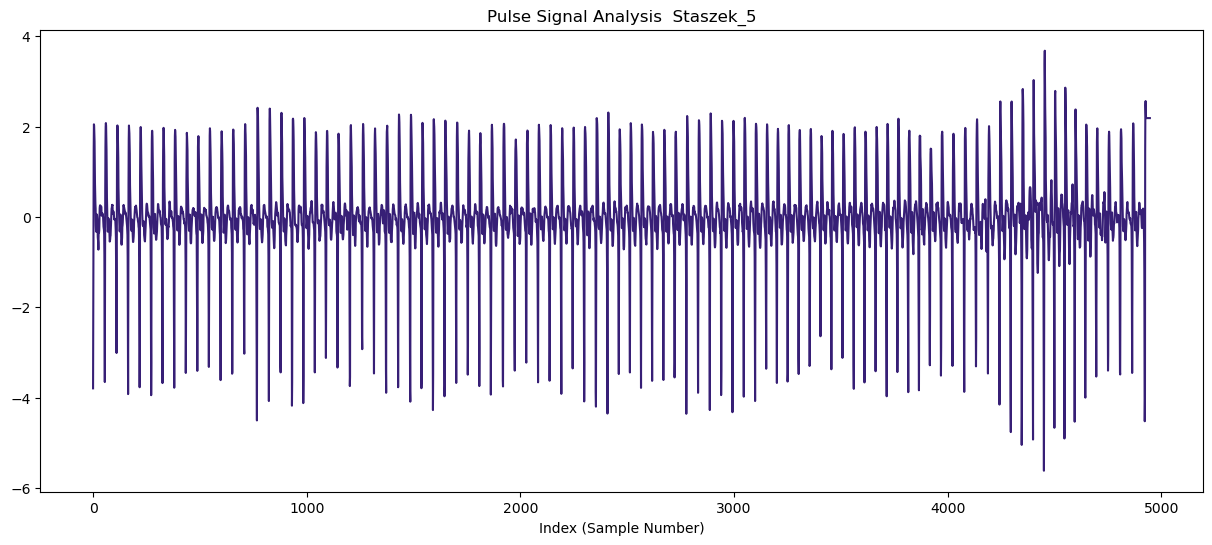

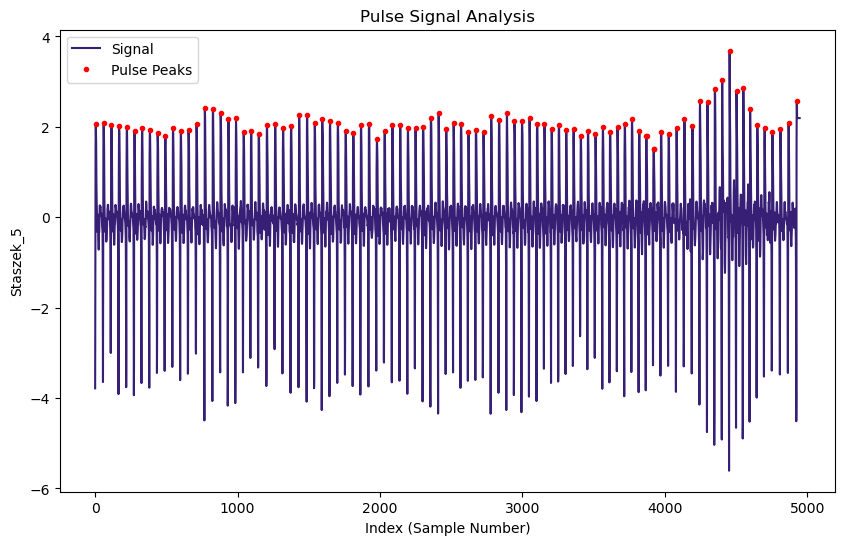

In [2214]:
sampling_rate = 100
for i in range(10):
    for j in range(2):
        heart_rate, pulse_peaks = analyze_pulse(df[df.columns[i * 2 +j]], sampling_rate)
        print(f'Heart Rate for {df.columns[i * 2 +j]}: {heart_rate} beats per minute')
        plot_signal_with_peaks(df[df.columns[i * 2 +j]], pulse_peaks, df.columns[i * 2 +j])

# Spostrzeżenia
- Według odczytów laserowych z niezależnego urządzenia pomiarowego tętno wynosiło 70 bpm.
- Druga metoda daje wartości dużo bardziej zbliżone do tych z sygnału optycznego.
- Zastosowanie opaski uciskowej na ramieniu skutecznie zagłusza sygnał.
- Obiekt badań stresował się podczas pomiaru.

# TO DO
- Raport

# Notatki do raportu
- Zestawić dane HR wyliczone przez skrypt z danymi rzeczywistymi w pliku ```references.txt```
- Tkanka tłuszczowa skutecznie zagłusza sygnał (co widać na Staszku 😐 - wartości kompletnie się nie pokrywają)
- Sygnały zebrane z dzieci posiadają nieregularne zagłuszenia (mogące wynikać m.in. z faktu, że podczas pomiaru nie należy się poruszać)
- Szumy i dźwięki z otoczenia nie wpływają na pomiar (muzyka rock lecąca w tle nie wpływała na pomiar, natomiast nawet najmniejszy ruch już tak (oczywiście negatywnie))
- Na niektórych pomiarach zaobserwowano nagły wzrost i spadek napięcia (efekt fali na wykresach)
- Sposób modulacji oddechu wpływa na wartość napięcia rejestrowaną przez miktrofon
- Układ nie nadaje się do pomiarów z okolic szyi i klatki piersiowej - oddech skutecznie zaburza jakąkolwiek inforamcję w sygnale
- Na niektórych fragmentach da się zaobserwować załamki przypominające QRS z sygnału EKG, zwłaszcza piki R